In [1]:
import sys, os
import numpy as np
import pandas as pd
import random
from random import shuffle, choice
import time
import os
import glob
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from random import shuffle, choice
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler

batch_size = 250
epochs = 100
epochs_traits = 500
num_classes = 3

class LinearW(Layer):

    def __init__(self):
        super(LinearW, self).__init__()
        
    def build(self, input_shape):

        self.W = self.add_weight(name='name',
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
        
    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

def create_mlp(traitstrain, regularizer=None):
  """Creates a three-layer MLP with inputs of the given dimension"""
  model = Sequential()
  model.add(Dense(150, use_bias=False, input_dim=traitstrain.shape[1], activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(150, use_bias=False, activation="relu"))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation="relu"))
  return model


def create_cnn(xtest, regularizer=None):
  inputShape = (xtest.shape[1], xtest.shape[2])
  inputs = Input(shape=inputShape)
  x = inputs
  x = Conv1D(125, kernel_size=3, activation='relu', use_bias=False, input_shape=(xtest.shape[1], xtest.shape[2]))(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=3)(x)
  x = Flatten()(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
  x = Dense(50, kernel_regularizer=regularizer)(x)
  x = Activation("relu")(x)
  # Construct the CNN
  model = Model(inputs, x)
  # Return the CNN
  return model

2023-03-20 13:06:06.783350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 13:06:06.904203: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
traits_BM = []
traits_BM = np.loadtxt("./traits/traits_BM.txt").reshape(30000,-1,100)
traits_BM = np.array(traits_BM)

#Standard scale the continuous variables
scalers_BM = {}
for i in range(traits_BM.shape[2]):
    scalers_BM[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers_BM[i].fit_transform(traits_BM[:, :, i]) 

Traits_BM = np.array(traits_BM)

u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

u=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(u):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            u[arr][idx][u[arr][idx] == 1] = -1
            u[arr][idx][u[arr][idx] == 0] = 1
        else:
            u[arr][idx][u[arr][idx] == 0] = -1


In [3]:
################################################################################################################################################
#20% Missing Data SNPs
################################################################################################################################################
X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


2023-03-15 11:19:36.355504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 11:19:36.974392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22085 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [4]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 998, 125)     22500       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 998, 125)    500         ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 996, 250)     93750       ['batch_normalization_2[0][

2023-03-15 11:19:42.198841: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-15 11:19:42.370739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-15 11:19:43.834222: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 11:19:43.835906: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 11:19:43.835922: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-15 11:19:43.837582: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 11:19:43.837628: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

90/90 [==============================] - 15s 104ms/step - loss: 11.0046 - accuracy: 0.3891 - val_loss: 10.8814 - val_accuracy: 0.4569
Epoch 2/100
90/90 [==============================] - 8s 90ms/step - loss: 10.7722 - accuracy: 0.4930 - val_loss: 10.7273 - val_accuracy: 0.5636
Epoch 3/100
90/90 [==============================] - 8s 91ms/step - loss: 10.6215 - accuracy: 0.5570 - val_loss: 10.5413 - val_accuracy: 0.6020
Epoch 4/100
90/90 [==============================] - 8s 90ms/step - loss: 10.5124 - accuracy: 0.6028 - val_loss: 10.3868 - val_accuracy: 0.6661
Epoch 5/100
90/90 [==============================] - 8s 91ms/step - loss: 10.4095 - accuracy: 0.6396 - val_loss: 10.2609 - val_accuracy: 0.7101
Epoch 6/100
90/90 [==============================] - 9s 97ms/step - loss: 10.3094 - accuracy: 0.6712 - val_loss: 10.1476 - val_accuracy: 0.7525
Epoch 7/100
90/90 [==============================] - 8s 93ms/step - loss: 10.2207 - accuracy: 0.6985 - val_loss: 10.0519 - val_accuracy: 0.7980
Ep

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [5]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/MD_Ind_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d (Conv1D)             (None, 998, 125)          22500     
                                                                 
 batch_normalization_2 (Batc  (None, 998, 125)         500       
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 250)          93750     
                                                                 
 batch_normalization_3 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 994, 250)          1875

Epoch 39/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0120 - val_accuracy: 0.9969
Epoch 40/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0126 - accuracy: 0.9964 - val_loss: 0.0129 - val_accuracy: 0.9971
Epoch 41/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0129 - val_accuracy: 0.9969
Epoch 42/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.0134 - val_accuracy: 0.9971
Epoch 43/100
90/90 [==============================] - 8s 91ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.0131 - val_accuracy: 0.9973
Epoch 44/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0103 - accuracy: 0.9968 - val_loss: 0.0132 - val_accuracy: 0.9972
Epoch 45/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0121 - val_accuracy: 0.9973

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod/assets


In [6]:
################################################################################################################################################
# 40% Missing Data SNPs
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [7]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 998, 125)     22500       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 998, 125)    500         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)              (None, 996, 250)     93750       ['batch_normalization_7[0][

90/90 [==============================] - 9s 97ms/step - loss: 7.1307 - accuracy: 0.9928 - val_loss: 7.1114 - val_accuracy: 0.9937
Epoch 74/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0924 - accuracy: 0.9949 - val_loss: 7.0755 - val_accuracy: 0.9935
Epoch 75/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0609 - accuracy: 0.9937 - val_loss: 7.0429 - val_accuracy: 0.9935
Epoch 76/100
90/90 [==============================] - 8s 94ms/step - loss: 7.0239 - accuracy: 0.9944 - val_loss: 7.0105 - val_accuracy: 0.9931
Epoch 77/100
90/90 [==============================] - 8s 93ms/step - loss: 6.9907 - accuracy: 0.9942 - val_loss: 6.9743 - val_accuracy: 0.9937
Epoch 78/100
90/90 [==============================] - 8s 93ms/step - loss: 6.9563 - accuracy: 0.9952 - val_loss: 6.9397 - val_accuracy: 0.9937
Epoch 79/100
90/90 [==============================] - 9s 96ms/step - loss: 6.9207 - accuracy: 0.9948 - val_loss: 6.9061 - val_accuracy: 0.9939
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [8]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/MD_Ind_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 998, 125)          22500     
                                                                 
 batch_normalization_7 (Batc  (None, 998, 125)         500       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 996, 250)          93750     
                                                                 
 batch_normalization_8 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 994, 250)          1875

Epoch 39/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 0.0215 - val_accuracy: 0.9953
Epoch 40/100
90/90 [==============================] - 8s 91ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0226 - val_accuracy: 0.9948
Epoch 41/100
90/90 [==============================] - 8s 92ms/step - loss: 0.0137 - accuracy: 0.9965 - val_loss: 0.0220 - val_accuracy: 0.9951
Epoch 42/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.0210 - val_accuracy: 0.9952
Epoch 43/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.0208 - val_accuracy: 0.9953
Epoch 44/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.0228 - val_accuracy: 0.9951
Epoch 45/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.0224 - val_accuracy: 0.9951

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod/assets


In [9]:
################################################################################################################################################
# 60% Missing Data SNPs
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
#missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [10]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 998, 125)     22500       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 998, 125)    500         ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 996, 250)     93750       ['batch_normalization_12[0]

90/90 [==============================] - 9s 95ms/step - loss: 7.1458 - accuracy: 0.9878 - val_loss: 7.1357 - val_accuracy: 0.9832
Epoch 74/100
90/90 [==============================] - 9s 95ms/step - loss: 7.1118 - accuracy: 0.9871 - val_loss: 7.0994 - val_accuracy: 0.9841
Epoch 75/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0757 - accuracy: 0.9879 - val_loss: 7.0658 - val_accuracy: 0.9845
Epoch 76/100
90/90 [==============================] - 8s 92ms/step - loss: 7.0396 - accuracy: 0.9880 - val_loss: 7.0316 - val_accuracy: 0.9844
Epoch 77/100
90/90 [==============================] - 8s 92ms/step - loss: 7.0042 - accuracy: 0.9890 - val_loss: 6.9955 - val_accuracy: 0.9852
Epoch 78/100
90/90 [==============================] - 9s 95ms/step - loss: 6.9658 - accuracy: 0.9901 - val_loss: 6.9597 - val_accuracy: 0.9859
Epoch 79/100
90/90 [==============================] - 8s 93ms/step - loss: 6.9312 - accuracy: 0.9898 - val_loss: 6.9267 - val_accuracy: 0.9860
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [11]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/MD_Ind_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 998, 125)          22500     
                                                                 
 batch_normalization_12 (Bat  (None, 998, 125)         500       
 chNormalization)                                                
                                                                 
 conv1d_7 (Conv1D)           (None, 996, 250)          93750     
                                                                 
 batch_normalization_13 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_8 (Conv1D)           (None, 994, 250)          1875

Epoch 39/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0144 - accuracy: 0.9963 - val_loss: 0.0372 - val_accuracy: 0.9905
Epoch 40/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0150 - accuracy: 0.9957 - val_loss: 0.0374 - val_accuracy: 0.9901
Epoch 41/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.0396 - val_accuracy: 0.9896
Epoch 42/100
90/90 [==============================] - 8s 90ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.0424 - val_accuracy: 0.9896
Epoch 43/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.0386 - val_accuracy: 0.9896
Epoch 44/100
90/90 [==============================] - 8s 89ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.0387 - val_accuracy: 0.9896
Epoch 45/100
90/90 [==============================] - 8s 92ms/step - loss: 0.0141 - accuracy: 0.9963 - val_loss: 0.0403 - val_accuracy: 0.9895

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod/assets


In [12]:
################################################################################################################################################
#20% Missing Data BM
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
#missD = int(traits_BM.shape[1]*traits_BM.shape[2]*(missD_perc/100))
missD = int(traits_BM.shape[1]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    traits_BM[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [13]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 998, 125)     22500       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 998, 125)    500         ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_17[0

Epoch 17/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2330 - accuracy: 0.9754 - val_loss: 9.1496 - val_accuracy: 0.9960
Epoch 18/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1879 - accuracy: 0.9790 - val_loss: 9.1071 - val_accuracy: 0.9969
Epoch 19/100
90/90 [==============================] - 8s 94ms/step - loss: 9.1426 - accuracy: 0.9802 - val_loss: 9.0655 - val_accuracy: 0.9977
Epoch 20/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0993 - accuracy: 0.9814 - val_loss: 9.0270 - val_accuracy: 0.9975
Epoch 21/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0582 - accuracy: 0.9820 - val_loss: 8.9872 - val_accuracy: 0.9977
Epoch 22/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0145 - accuracy: 0.9841 - val_loss: 8.9496 - val_accuracy: 0.9972
Epoch 23/100
90/90 [==============================] - 9s 95ms/step - loss: 8.9722 - accuracy: 0.9853 - val_loss: 8.9083 - val_accuracy: 0.9981

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [14]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_BM_20_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_27 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_15 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_16 (Bat  (None, 150)              600       
 chNormalization)                                       

Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3944 - accuracy: 0.9913 - val_loss: 4.0330 - val_accuracy: 0.6704
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3696 - accuracy: 0.9925 - val_loss: 4.0104 - val_accuracy: 0.6715
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3428 - accuracy: 0.9928 - val_loss: 3.9881 - val_accuracy: 0.6711
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3173 - accuracy: 0.9941 - val_loss: 3.9655 - val_accuracy: 0.6717
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2909 - accuracy: 0.9934 - val_loss: 3.9428 - val_accuracy: 0.6720
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2647 - accuracy: 0.9943 - val_loss: 3.9206 - val_accuracy: 0.6727
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2390 - accuracy: 0.9950 - val_loss: 3.8986 - val_accuracy: 0.6

90/90 [==============================] - 1s 11ms/step - loss: 1.1595 - accuracy: 1.0000 - val_loss: 1.9861 - val_accuracy: 0.7104
Epoch 220/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1456 - accuracy: 1.0000 - val_loss: 1.9734 - val_accuracy: 0.7099
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1320 - accuracy: 1.0000 - val_loss: 1.9595 - val_accuracy: 0.7105
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1179 - accuracy: 1.0000 - val_loss: 1.9457 - val_accuracy: 0.7103
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1043 - accuracy: 1.0000 - val_loss: 1.9331 - val_accuracy: 0.7096
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0908 - accuracy: 1.0000 - val_loss: 1.9194 - val_accuracy: 0.7104
Epoch 225/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0776 - accuracy: 1.0000 - val_loss: 1.9073 - val_accuracy: 0.7124
Epoch 22

90/90 [==============================] - 1s 10ms/step - loss: 0.8934 - accuracy: 0.8288 - val_loss: 1.6547 - val_accuracy: 0.6585
Epoch 334/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5798 - accuracy: 0.9455 - val_loss: 1.1010 - val_accuracy: 0.7828
Epoch 335/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4514 - accuracy: 0.9917 - val_loss: 1.0453 - val_accuracy: 0.7865
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3948 - accuracy: 0.9998 - val_loss: 1.0229 - val_accuracy: 0.7835
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3556 - accuracy: 1.0000 - val_loss: 1.0031 - val_accuracy: 0.7816
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3239 - accuracy: 1.0000 - val_loss: 0.9780 - val_accuracy: 0.7799
Epoch 339/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2971 - accuracy: 1.0000 - val_loss: 0.9483 - val_accuracy: 0.7821
Epoch 340

90/90 [==============================] - 1s 9ms/step - loss: 0.5679 - accuracy: 0.9147 - val_loss: 1.0358 - val_accuracy: 0.7740
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3889 - accuracy: 0.9831 - val_loss: 0.7537 - val_accuracy: 0.8469
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3204 - accuracy: 0.9983 - val_loss: 0.7133 - val_accuracy: 0.8523
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2775 - accuracy: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.8452
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2437 - accuracy: 1.0000 - val_loss: 0.6622 - val_accuracy: 0.8459
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2156 - accuracy: 1.0000 - val_loss: 0.6342 - val_accuracy: 0.8487
Epoch 453/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1915 - accuracy: 1.0000 - val_loss: 0.6061 - val_accuracy: 0.8531
Epoch 454/50

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_20_Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_20_Trained_Traits_Model_100BM.acc.mod/assets


In [3]:
################################################################################################################################################
#40% Missing Data BM
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)


y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_BM.shape[1]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    traits_BM[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


2023-03-20 13:08:50.697790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 13:08:51.320028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22000 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [16]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 998, 125)     22500       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 998, 125)    500         ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_22[0

Epoch 17/100
90/90 [==============================] - 8s 93ms/step - loss: 9.2525 - accuracy: 0.9732 - val_loss: 9.1643 - val_accuracy: 0.9948
Epoch 18/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2058 - accuracy: 0.9760 - val_loss: 9.1243 - val_accuracy: 0.9941
Epoch 19/100
90/90 [==============================] - 9s 97ms/step - loss: 9.1614 - accuracy: 0.9772 - val_loss: 9.0819 - val_accuracy: 0.9951
Epoch 20/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1162 - accuracy: 0.9796 - val_loss: 9.0418 - val_accuracy: 0.9961
Epoch 21/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0714 - accuracy: 0.9819 - val_loss: 9.0019 - val_accuracy: 0.9959
Epoch 22/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0302 - accuracy: 0.9811 - val_loss: 8.9615 - val_accuracy: 0.9967
Epoch 23/100
90/90 [==============================] - 8s 93ms/step - loss: 8.9862 - accuracy: 0.9832 - val_loss: 8.9251 - val_accuracy: 0.9957

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [4]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_BM_40_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 3000)]            0         
                                                                 
 dense (Dense)               (None, 150)               450000    
                                                                 
 batch_normalization (BatchN  (None, 150)              600       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_1 (Batc  (None, 150)              600       
 hNormalization)                                         

2023-03-20 13:08:54.939059: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


90/90 [==============================] - 3s 14ms/step - loss: 11.1191 - accuracy: 0.3501 - val_loss: 10.9472 - val_accuracy: 0.3511
Epoch 2/500
90/90 [==============================] - 1s 10ms/step - loss: 10.9353 - accuracy: 0.3912 - val_loss: 10.8493 - val_accuracy: 0.3964
Epoch 3/500
90/90 [==============================] - 1s 9ms/step - loss: 10.8001 - accuracy: 0.4420 - val_loss: 10.7473 - val_accuracy: 0.4564
Epoch 4/500
90/90 [==============================] - 1s 10ms/step - loss: 10.6928 - accuracy: 0.4851 - val_loss: 10.6600 - val_accuracy: 0.4888
Epoch 5/500
90/90 [==============================] - 1s 10ms/step - loss: 10.6026 - accuracy: 0.5181 - val_loss: 10.5868 - val_accuracy: 0.5145
Epoch 6/500
90/90 [==============================] - 1s 10ms/step - loss: 10.5254 - accuracy: 0.5445 - val_loss: 10.5224 - val_accuracy: 0.5291
Epoch 7/500
90/90 [==============================] - 1s 9ms/step - loss: 10.4562 - accuracy: 0.5567 - val_loss: 10.4632 - val_accuracy: 0.5391
Epoch 

90/90 [==============================] - 1s 9ms/step - loss: 8.1094 - accuracy: 0.8018 - val_loss: 8.3610 - val_accuracy: 0.6104
Epoch 59/500
90/90 [==============================] - 1s 9ms/step - loss: 8.0679 - accuracy: 0.8070 - val_loss: 8.3249 - val_accuracy: 0.6100
Epoch 60/500
90/90 [==============================] - 1s 9ms/step - loss: 8.0280 - accuracy: 0.8113 - val_loss: 8.2891 - val_accuracy: 0.6096
Epoch 61/500
90/90 [==============================] - 1s 10ms/step - loss: 7.9877 - accuracy: 0.8126 - val_loss: 8.2533 - val_accuracy: 0.6104
Epoch 62/500
90/90 [==============================] - 1s 9ms/step - loss: 7.9478 - accuracy: 0.8148 - val_loss: 8.2178 - val_accuracy: 0.6105
Epoch 63/500
90/90 [==============================] - 1s 9ms/step - loss: 7.9081 - accuracy: 0.8175 - val_loss: 8.1822 - val_accuracy: 0.6104
Epoch 64/500
90/90 [==============================] - 1s 10ms/step - loss: 7.8664 - accuracy: 0.8233 - val_loss: 8.1465 - val_accuracy: 0.6107
Epoch 65/500
90/9

90/90 [==============================] - 1s 10ms/step - loss: 5.9595 - accuracy: 0.9510 - val_loss: 6.4939 - val_accuracy: 0.6317
Epoch 116/500
90/90 [==============================] - 1s 10ms/step - loss: 5.9253 - accuracy: 0.9531 - val_loss: 6.4642 - val_accuracy: 0.6328
Epoch 117/500
90/90 [==============================] - 1s 11ms/step - loss: 5.8893 - accuracy: 0.9553 - val_loss: 6.4346 - val_accuracy: 0.6327
Epoch 118/500
90/90 [==============================] - 1s 10ms/step - loss: 5.8556 - accuracy: 0.9563 - val_loss: 6.4052 - val_accuracy: 0.6317
Epoch 119/500
90/90 [==============================] - 1s 9ms/step - loss: 5.8214 - accuracy: 0.9583 - val_loss: 6.3761 - val_accuracy: 0.6323
Epoch 120/500
90/90 [==============================] - 1s 9ms/step - loss: 5.7870 - accuracy: 0.9600 - val_loss: 6.3467 - val_accuracy: 0.6319
Epoch 121/500
90/90 [==============================] - 1s 9ms/step - loss: 5.7536 - accuracy: 0.9606 - val_loss: 6.3179 - val_accuracy: 0.6319
Epoch 122

90/90 [==============================] - 1s 10ms/step - loss: 4.1794 - accuracy: 0.9970 - val_loss: 4.9558 - val_accuracy: 0.6469
Epoch 173/500
90/90 [==============================] - 1s 9ms/step - loss: 4.1510 - accuracy: 0.9973 - val_loss: 4.9316 - val_accuracy: 0.6463
Epoch 174/500
90/90 [==============================] - 1s 9ms/step - loss: 4.1245 - accuracy: 0.9970 - val_loss: 4.9072 - val_accuracy: 0.6461
Epoch 175/500
90/90 [==============================] - 1s 9ms/step - loss: 4.0966 - accuracy: 0.9973 - val_loss: 4.8831 - val_accuracy: 0.6465
Epoch 176/500
90/90 [==============================] - 1s 9ms/step - loss: 4.0694 - accuracy: 0.9976 - val_loss: 4.8586 - val_accuracy: 0.6472
Epoch 177/500
90/90 [==============================] - 1s 9ms/step - loss: 4.0417 - accuracy: 0.9979 - val_loss: 4.8344 - val_accuracy: 0.6468
Epoch 178/500
90/90 [==============================] - 1s 9ms/step - loss: 4.0147 - accuracy: 0.9978 - val_loss: 4.8105 - val_accuracy: 0.6464
Epoch 179/50

90/90 [==============================] - 1s 9ms/step - loss: 2.7666 - accuracy: 1.0000 - val_loss: 3.6867 - val_accuracy: 0.6569
Epoch 230/500
90/90 [==============================] - 1s 9ms/step - loss: 2.7446 - accuracy: 1.0000 - val_loss: 3.6669 - val_accuracy: 0.6580
Epoch 231/500
90/90 [==============================] - 1s 9ms/step - loss: 2.7231 - accuracy: 0.9999 - val_loss: 3.6474 - val_accuracy: 0.6583
Epoch 232/500
90/90 [==============================] - 1s 9ms/step - loss: 2.7009 - accuracy: 1.0000 - val_loss: 3.6274 - val_accuracy: 0.6583
Epoch 233/500
90/90 [==============================] - 1s 9ms/step - loss: 2.6795 - accuracy: 1.0000 - val_loss: 3.6078 - val_accuracy: 0.6580
Epoch 234/500
90/90 [==============================] - 1s 9ms/step - loss: 2.6580 - accuracy: 1.0000 - val_loss: 3.5883 - val_accuracy: 0.6596
Epoch 235/500
90/90 [==============================] - 1s 9ms/step - loss: 2.6367 - accuracy: 1.0000 - val_loss: 3.5684 - val_accuracy: 0.6587
Epoch 236/500

90/90 [==============================] - 1s 9ms/step - loss: 1.6654 - accuracy: 1.0000 - val_loss: 2.6648 - val_accuracy: 0.6692
Epoch 287/500
90/90 [==============================] - 1s 9ms/step - loss: 1.6488 - accuracy: 1.0000 - val_loss: 2.6490 - val_accuracy: 0.6695
Epoch 288/500
90/90 [==============================] - 1s 9ms/step - loss: 1.6325 - accuracy: 1.0000 - val_loss: 2.6330 - val_accuracy: 0.6689
Epoch 289/500
90/90 [==============================] - 1s 9ms/step - loss: 1.6155 - accuracy: 1.0000 - val_loss: 2.6182 - val_accuracy: 0.6704
Epoch 290/500
90/90 [==============================] - 1s 9ms/step - loss: 1.5998 - accuracy: 1.0000 - val_loss: 2.6026 - val_accuracy: 0.6707
Epoch 291/500
90/90 [==============================] - 1s 9ms/step - loss: 1.5834 - accuracy: 1.0000 - val_loss: 2.5876 - val_accuracy: 0.6712
Epoch 292/500
90/90 [==============================] - 1s 9ms/step - loss: 1.5669 - accuracy: 1.0000 - val_loss: 2.5723 - val_accuracy: 0.6716
Epoch 293/500

90/90 [==============================] - 1s 9ms/step - loss: 0.8583 - accuracy: 1.0000 - val_loss: 1.9145 - val_accuracy: 0.6847
Epoch 344/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8469 - accuracy: 1.0000 - val_loss: 1.9028 - val_accuracy: 0.6833
Epoch 345/500
90/90 [==============================] - 1s 8ms/step - loss: 0.8348 - accuracy: 1.0000 - val_loss: 1.8929 - val_accuracy: 0.6841
Epoch 346/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8242 - accuracy: 1.0000 - val_loss: 1.8807 - val_accuracy: 0.6845
Epoch 347/500
90/90 [==============================] - 1s 8ms/step - loss: 0.8128 - accuracy: 1.0000 - val_loss: 1.8708 - val_accuracy: 0.6839
Epoch 348/500
90/90 [==============================] - 1s 8ms/step - loss: 0.8015 - accuracy: 1.0000 - val_loss: 1.8609 - val_accuracy: 0.6827
Epoch 349/500
90/90 [==============================] - 1s 8ms/step - loss: 0.7904 - accuracy: 1.0000 - val_loss: 1.8495 - val_accuracy: 0.6829
Epoch 350/500

90/90 [==============================] - 1s 9ms/step - loss: 0.3435 - accuracy: 1.0000 - val_loss: 1.4272 - val_accuracy: 0.6905
Epoch 401/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3370 - accuracy: 1.0000 - val_loss: 1.4189 - val_accuracy: 0.6907
Epoch 402/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3307 - accuracy: 1.0000 - val_loss: 1.4107 - val_accuracy: 0.6896
Epoch 403/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3233 - accuracy: 1.0000 - val_loss: 1.4019 - val_accuracy: 0.6875
Epoch 404/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3178 - accuracy: 1.0000 - val_loss: 1.4040 - val_accuracy: 0.6879
Epoch 405/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3115 - accuracy: 1.0000 - val_loss: 1.3928 - val_accuracy: 0.6880
Epoch 406/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3053 - accuracy: 1.0000 - val_loss: 1.3874 - val_accuracy: 0.6897
Epoch 407/500

90/90 [==============================] - 1s 9ms/step - loss: 0.1863 - accuracy: 1.0000 - val_loss: 1.1146 - val_accuracy: 0.7376
Epoch 458/500
90/90 [==============================] - 1s 8ms/step - loss: 0.1756 - accuracy: 1.0000 - val_loss: 1.1078 - val_accuracy: 0.7340
Epoch 459/500
90/90 [==============================] - 1s 8ms/step - loss: 0.1740 - accuracy: 0.9988 - val_loss: 1.2930 - val_accuracy: 0.7149
Epoch 460/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8648 - accuracy: 0.8381 - val_loss: 2.3810 - val_accuracy: 0.5676
Epoch 461/500
90/90 [==============================] - 1s 9ms/step - loss: 0.6346 - accuracy: 0.9288 - val_loss: 1.4430 - val_accuracy: 0.7055
Epoch 462/500
90/90 [==============================] - 1s 8ms/step - loss: 0.4731 - accuracy: 0.9880 - val_loss: 1.2684 - val_accuracy: 0.7424
Epoch 463/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4087 - accuracy: 0.9997 - val_loss: 1.2435 - val_accuracy: 0.7439
Epoch 464/500

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_40_Trained_Traits_Model_100BM.acc.mod/assets


In [18]:
################################################################################################################################################
# 60% Missing Data BM
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_BM.shape[1]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    traits_BM[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [19]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 998, 125)     22500       ['input_6[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 998, 125)    500         ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_27[0

Epoch 17/100
90/90 [==============================] - 8s 93ms/step - loss: 9.2428 - accuracy: 0.9759 - val_loss: 9.1576 - val_accuracy: 0.9969
Epoch 18/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1962 - accuracy: 0.9785 - val_loss: 9.1172 - val_accuracy: 0.9969
Epoch 19/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1547 - accuracy: 0.9787 - val_loss: 9.0786 - val_accuracy: 0.9968
Epoch 20/100
90/90 [==============================] - 9s 99ms/step - loss: 9.1112 - accuracy: 0.9802 - val_loss: 9.0364 - val_accuracy: 0.9973
Epoch 21/100
90/90 [==============================] - 9s 98ms/step - loss: 9.0664 - accuracy: 0.9822 - val_loss: 8.9961 - val_accuracy: 0.9979
Epoch 22/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0212 - accuracy: 0.9842 - val_loss: 8.9559 - val_accuracy: 0.9983
Epoch 23/100
90/90 [==============================] - 8s 92ms/step - loss: 8.9792 - accuracy: 0.9852 - val_loss: 8.9165 - val_accuracy: 0.9987

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [20]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_BM_60_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_45 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_25 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_46 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_26 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 9ms/step - loss: 3.4423 - accuracy: 0.9885 - val_loss: 4.1914 - val_accuracy: 0.6209
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.4157 - accuracy: 0.9886 - val_loss: 4.1703 - val_accuracy: 0.6217
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3886 - accuracy: 0.9907 - val_loss: 4.1496 - val_accuracy: 0.6225
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3642 - accuracy: 0.9899 - val_loss: 4.1283 - val_accuracy: 0.6215
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3361 - accuracy: 0.9908 - val_loss: 4.1078 - val_accuracy: 0.6228
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3096 - accuracy: 0.9917 - val_loss: 4.0871 - val_accuracy: 0.6235
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2837 - accuracy: 0.9925 - val_loss: 4.0671 - val_accuracy: 0.6228
Epoch 111/5

90/90 [==============================] - 1s 9ms/step - loss: 1.1751 - accuracy: 1.0000 - val_loss: 2.3267 - val_accuracy: 0.6361
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1608 - accuracy: 1.0000 - val_loss: 2.3147 - val_accuracy: 0.6360
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1481 - accuracy: 1.0000 - val_loss: 2.3024 - val_accuracy: 0.6369
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1336 - accuracy: 1.0000 - val_loss: 2.2907 - val_accuracy: 0.6377
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1202 - accuracy: 1.0000 - val_loss: 2.2802 - val_accuracy: 0.6359
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1061 - accuracy: 1.0000 - val_loss: 2.2681 - val_accuracy: 0.6361
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0934 - accuracy: 1.0000 - val_loss: 2.2579 - val_accuracy: 0.6371
Epoch 225/50

90/90 [==============================] - 1s 9ms/step - loss: 0.2018 - accuracy: 1.0000 - val_loss: 1.4402 - val_accuracy: 0.6613
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1962 - accuracy: 1.0000 - val_loss: 1.4400 - val_accuracy: 0.6595
Epoch 334/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1912 - accuracy: 1.0000 - val_loss: 1.4303 - val_accuracy: 0.6603
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1856 - accuracy: 1.0000 - val_loss: 1.4468 - val_accuracy: 0.6573
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1828 - accuracy: 1.0000 - val_loss: 1.4361 - val_accuracy: 0.6583
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1779 - accuracy: 1.0000 - val_loss: 1.4311 - val_accuracy: 0.6596
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1715 - accuracy: 1.0000 - val_loss: 1.4287 - val_accuracy: 0.6613
Epoch 339/50

90/90 [==============================] - 1s 9ms/step - loss: 0.2851 - accuracy: 1.0000 - val_loss: 1.1627 - val_accuracy: 0.7235
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2578 - accuracy: 1.0000 - val_loss: 1.1400 - val_accuracy: 0.7249
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2331 - accuracy: 1.0000 - val_loss: 1.1164 - val_accuracy: 0.7265
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2110 - accuracy: 1.0000 - val_loss: 1.0934 - val_accuracy: 0.7291
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1913 - accuracy: 1.0000 - val_loss: 1.0742 - val_accuracy: 0.7320
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1731 - accuracy: 1.0000 - val_loss: 1.0521 - val_accuracy: 0.7341
Epoch 452/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1573 - accuracy: 1.0000 - val_loss: 1.0351 - val_accuracy: 0.7373
Epoch 453/5

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_60_Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_BM_60_Trained_Traits_Model_100BM.acc.mod/assets


In [21]:
traits_OU = []
traits_OU = np.loadtxt("./traits/traits_OU.txt").reshape(30000,-1,100)

traits_OU = np.array(traits_OU)

#This is not behaving well. I need to use another scaling scheme.
scalers_OU = {}
for i in range(traits_OU.shape[2]):
    scalers_OU[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers_OU[i].fit_transform(traits_OU[:, :, i]) 

Traits_OU = np.array(traits_OU)

In [22]:
################################################################################################################################################
#20% Missing Data SNPs
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [23]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 998, 125)     22500       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 998, 125)    500         ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_32[0

90/90 [==============================] - 8s 92ms/step - loss: 7.1097 - accuracy: 0.9947 - val_loss: 7.0786 - val_accuracy: 0.9980
Epoch 74/100
90/90 [==============================] - 8s 92ms/step - loss: 7.0742 - accuracy: 0.9942 - val_loss: 7.0440 - val_accuracy: 0.9980
Epoch 75/100
90/90 [==============================] - 8s 91ms/step - loss: 7.0403 - accuracy: 0.9946 - val_loss: 7.0089 - val_accuracy: 0.9981
Epoch 76/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0043 - accuracy: 0.9952 - val_loss: 6.9752 - val_accuracy: 0.9983
Epoch 77/100
90/90 [==============================] - 8s 94ms/step - loss: 6.9686 - accuracy: 0.9964 - val_loss: 6.9412 - val_accuracy: 0.9981
Epoch 78/100
90/90 [==============================] - 8s 91ms/step - loss: 6.9368 - accuracy: 0.9952 - val_loss: 6.9070 - val_accuracy: 0.9980
Epoch 79/100
90/90 [==============================] - 8s 94ms/step - loss: 6.9018 - accuracy: 0.9950 - val_loss: 6.8726 - val_accuracy: 0.9984
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [24]:
################################################################################################################################################
#40% Missing Data SNPs
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [25]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 998, 125)     22500       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_37 (BatchN  (None, 998, 125)    500         ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_37[0

90/90 [==============================] - 8s 91ms/step - loss: 7.1363 - accuracy: 0.9920 - val_loss: 7.1122 - val_accuracy: 0.9932
Epoch 74/100
90/90 [==============================] - 8s 90ms/step - loss: 7.1003 - accuracy: 0.9926 - val_loss: 7.0783 - val_accuracy: 0.9928
Epoch 75/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0666 - accuracy: 0.9924 - val_loss: 7.0436 - val_accuracy: 0.9932
Epoch 76/100
90/90 [==============================] - 8s 92ms/step - loss: 7.0318 - accuracy: 0.9921 - val_loss: 7.0099 - val_accuracy: 0.9936
Epoch 77/100
90/90 [==============================] - 8s 90ms/step - loss: 6.9957 - accuracy: 0.9932 - val_loss: 6.9745 - val_accuracy: 0.9936
Epoch 78/100
90/90 [==============================] - 8s 91ms/step - loss: 6.9591 - accuracy: 0.9943 - val_loss: 6.9400 - val_accuracy: 0.9937
Epoch 79/100
90/90 [==============================] - 8s 91ms/step - loss: 6.9266 - accuracy: 0.9932 - val_loss: 6.9068 - val_accuracy: 0.9932
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [26]:
################################################################################################################################################
#60% Missing Data SNPs
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [27]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 998, 125)     22500       ['input_9[0][0]']                
                                                                                                  
 batch_normalization_42 (BatchN  (None, 998, 125)    500         ['conv1d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_25 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_42[0

90/90 [==============================] - 9s 95ms/step - loss: 7.1553 - accuracy: 0.9899 - val_loss: 7.1377 - val_accuracy: 0.9880
Epoch 74/100
90/90 [==============================] - 8s 91ms/step - loss: 7.1205 - accuracy: 0.9904 - val_loss: 7.1040 - val_accuracy: 0.9865
Epoch 75/100
90/90 [==============================] - 8s 91ms/step - loss: 7.0851 - accuracy: 0.9896 - val_loss: 7.0691 - val_accuracy: 0.9876
Epoch 76/100
90/90 [==============================] - 8s 91ms/step - loss: 7.0480 - accuracy: 0.9914 - val_loss: 7.0345 - val_accuracy: 0.9875
Epoch 77/100
90/90 [==============================] - 8s 90ms/step - loss: 7.0129 - accuracy: 0.9917 - val_loss: 6.9999 - val_accuracy: 0.9873
Epoch 78/100
90/90 [==============================] - 8s 91ms/step - loss: 6.9804 - accuracy: 0.9907 - val_loss: 6.9641 - val_accuracy: 0.9889
Epoch 79/100
90/90 [==============================] - 8s 91ms/step - loss: 6.9417 - accuracy: 0.9919 - val_loss: 6.9301 - val_accuracy: 0.9891
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [28]:
################################################################################################################################################
# 20% Missing Data OU
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_OU.shape[1]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    traits_OU[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [29]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 998, 125)     22500       ['input_10[0][0]']               
                                                                                                  
 batch_normalization_47 (BatchN  (None, 998, 125)    500         ['conv1d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_28 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_47[0

Epoch 17/100
90/90 [==============================] - 8s 91ms/step - loss: 9.2406 - accuracy: 0.9706 - val_loss: 9.1423 - val_accuracy: 0.9936
Epoch 18/100
90/90 [==============================] - 8s 91ms/step - loss: 9.1927 - accuracy: 0.9723 - val_loss: 9.1003 - val_accuracy: 0.9951
Epoch 19/100
90/90 [==============================] - 9s 95ms/step - loss: 9.1491 - accuracy: 0.9731 - val_loss: 9.0585 - val_accuracy: 0.9960
Epoch 20/100
90/90 [==============================] - 8s 91ms/step - loss: 9.0983 - accuracy: 0.9776 - val_loss: 9.0180 - val_accuracy: 0.9953
Epoch 21/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0549 - accuracy: 0.9788 - val_loss: 8.9775 - val_accuracy: 0.9963
Epoch 22/100
90/90 [==============================] - 8s 91ms/step - loss: 9.0140 - accuracy: 0.9791 - val_loss: 8.9383 - val_accuracy: 0.9965
Epoch 23/100
90/90 [==============================] - 8s 92ms/step - loss: 8.9671 - accuracy: 0.9815 - val_loss: 8.8979 - val_accuracy: 0.9971

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [30]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_OU_20_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_78 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_45 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_79 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_46 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 3.3774 - accuracy: 0.9980 - val_loss: 4.0719 - val_accuracy: 0.6625
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3512 - accuracy: 0.9985 - val_loss: 4.0492 - val_accuracy: 0.6625
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3262 - accuracy: 0.9983 - val_loss: 4.0261 - val_accuracy: 0.6645
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3007 - accuracy: 0.9984 - val_loss: 4.0035 - val_accuracy: 0.6645
Epoch 108/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2751 - accuracy: 0.9986 - val_loss: 3.9810 - val_accuracy: 0.6661
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2497 - accuracy: 0.9988 - val_loss: 3.9584 - val_accuracy: 0.6673
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2250 - accuracy: 0.9986 - val_loss: 3.9361 - val_accuracy: 0.6667
Epoch 111

90/90 [==============================] - 1s 10ms/step - loss: 1.1638 - accuracy: 1.0000 - val_loss: 1.9937 - val_accuracy: 0.7083
Epoch 219/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1498 - accuracy: 1.0000 - val_loss: 1.9798 - val_accuracy: 0.7079
Epoch 220/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1362 - accuracy: 1.0000 - val_loss: 1.9673 - val_accuracy: 0.7077
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1225 - accuracy: 1.0000 - val_loss: 1.9535 - val_accuracy: 0.7081
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1089 - accuracy: 1.0000 - val_loss: 1.9400 - val_accuracy: 0.7083
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0950 - accuracy: 1.0000 - val_loss: 1.9265 - val_accuracy: 0.7077
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0821 - accuracy: 1.0000 - val_loss: 1.9140 - val_accuracy: 0.7079
Epoch 2

90/90 [==============================] - 1s 9ms/step - loss: 0.3818 - accuracy: 1.0000 - val_loss: 1.0390 - val_accuracy: 0.7871
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3503 - accuracy: 1.0000 - val_loss: 1.0195 - val_accuracy: 0.7863
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3222 - accuracy: 1.0000 - val_loss: 0.9945 - val_accuracy: 0.7848
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2970 - accuracy: 1.0000 - val_loss: 0.9715 - val_accuracy: 0.7852
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2746 - accuracy: 1.0000 - val_loss: 0.9496 - val_accuracy: 0.7856
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2544 - accuracy: 1.0000 - val_loss: 0.9290 - val_accuracy: 0.7847
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2366 - accuracy: 1.0000 - val_loss: 0.9106 - val_accuracy: 0.7861
Epoch 339/5

90/90 [==============================] - 1s 11ms/step - loss: 0.1451 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.8592
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1301 - accuracy: 1.0000 - val_loss: 0.5559 - val_accuracy: 0.8616
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1175 - accuracy: 1.0000 - val_loss: 0.5421 - val_accuracy: 0.8620
Epoch 449/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1064 - accuracy: 1.0000 - val_loss: 0.5277 - val_accuracy: 0.8628
Epoch 450/500
90/90 [==============================] - 1s 10ms/step - loss: 0.0996 - accuracy: 1.0000 - val_loss: 0.5171 - val_accuracy: 0.8668
Epoch 451/500
90/90 [==============================] - 1s 10ms/step - loss: 0.0912 - accuracy: 1.0000 - val_loss: 0.5075 - val_accuracy: 0.8692
Epoch 452/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1683 - accuracy: 0.9797 - val_loss: 3.1297 - val_accuracy: 0.5640
Epoch 

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_20_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_20_Trained_Traits_Model_100OU.acc.mod/assets


In [31]:
################################################################################################################################################
# 40% Missing Data OU
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_OU.shape[1]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    traits_OU[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [32]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 998, 125)     22500       ['input_11[0][0]']               
                                                                                                  
 batch_normalization_52 (BatchN  (None, 998, 125)    500         ['conv1d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_31 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_52[0

Epoch 16/100
90/90 [==============================] - 8s 91ms/step - loss: 9.3368 - accuracy: 0.9580 - val_loss: 9.2156 - val_accuracy: 0.9923
Epoch 17/100
90/90 [==============================] - 8s 91ms/step - loss: 9.2834 - accuracy: 0.9636 - val_loss: 9.1705 - val_accuracy: 0.9941
Epoch 18/100
90/90 [==============================] - 9s 96ms/step - loss: 9.2381 - accuracy: 0.9653 - val_loss: 9.1287 - val_accuracy: 0.9947
Epoch 19/100
90/90 [==============================] - 8s 91ms/step - loss: 9.1818 - accuracy: 0.9718 - val_loss: 9.0867 - val_accuracy: 0.9947
Epoch 20/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1368 - accuracy: 0.9744 - val_loss: 9.0450 - val_accuracy: 0.9961
Epoch 21/100
90/90 [==============================] - 8s 91ms/step - loss: 9.0914 - accuracy: 0.9751 - val_loss: 9.0058 - val_accuracy: 0.9952
Epoch 22/100
90/90 [==============================] - 8s 91ms/step - loss: 9.0439 - accuracy: 0.9789 - val_loss: 8.9635 - val_accuracy: 0.9959

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [33]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_OU_40_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_87 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_50 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_88 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_51 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 5.1811 - accuracy: 0.8847 - val_loss: 5.6098 - val_accuracy: 0.5997
Epoch 48/500
90/90 [==============================] - 1s 10ms/step - loss: 5.1449 - accuracy: 0.8891 - val_loss: 5.5807 - val_accuracy: 0.6012
Epoch 49/500
90/90 [==============================] - 1s 10ms/step - loss: 5.1062 - accuracy: 0.8932 - val_loss: 5.5517 - val_accuracy: 0.6017
Epoch 50/500
90/90 [==============================] - 1s 10ms/step - loss: 5.0723 - accuracy: 0.8978 - val_loss: 5.5230 - val_accuracy: 0.6029
Epoch 51/500
90/90 [==============================] - 1s 10ms/step - loss: 5.0355 - accuracy: 0.9014 - val_loss: 5.4946 - val_accuracy: 0.6031
Epoch 52/500
90/90 [==============================] - 1s 10ms/step - loss: 5.0002 - accuracy: 0.9060 - val_loss: 5.4665 - val_accuracy: 0.6035
Epoch 53/500
90/90 [==============================] - 1s 10ms/step - loss: 4.9649 - accuracy: 0.9089 - val_loss: 5.4385 - val_accuracy: 0.6032
Epoch 54/500

90/90 [==============================] - 1s 10ms/step - loss: 2.1253 - accuracy: 1.0000 - val_loss: 3.0357 - val_accuracy: 0.6504
Epoch 162/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1063 - accuracy: 1.0000 - val_loss: 3.0185 - val_accuracy: 0.6499
Epoch 163/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0869 - accuracy: 1.0000 - val_loss: 3.0007 - val_accuracy: 0.6505
Epoch 164/500
90/90 [==============================] - 1s 11ms/step - loss: 2.0678 - accuracy: 1.0000 - val_loss: 2.9834 - val_accuracy: 0.6503
Epoch 165/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0490 - accuracy: 1.0000 - val_loss: 2.9663 - val_accuracy: 0.6496
Epoch 166/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0299 - accuracy: 1.0000 - val_loss: 2.9486 - val_accuracy: 0.6497
Epoch 167/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0112 - accuracy: 1.0000 - val_loss: 2.9309 - val_accuracy: 0.6500
Epoch 1

90/90 [==============================] - 1s 9ms/step - loss: 1.1757 - accuracy: 1.0000 - val_loss: 2.1614 - val_accuracy: 0.6636
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1618 - accuracy: 1.0000 - val_loss: 2.1495 - val_accuracy: 0.6631
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1478 - accuracy: 1.0000 - val_loss: 2.1363 - val_accuracy: 0.6632
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1341 - accuracy: 1.0000 - val_loss: 2.1236 - val_accuracy: 0.6641
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1199 - accuracy: 1.0000 - val_loss: 2.1109 - val_accuracy: 0.6640
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1067 - accuracy: 1.0000 - val_loss: 2.0983 - val_accuracy: 0.6640
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0934 - accuracy: 1.0000 - val_loss: 2.0856 - val_accuracy: 0.6644
Epoch 225

90/90 [==============================] - 1s 9ms/step - loss: 0.1671 - accuracy: 1.0000 - val_loss: 1.2728 - val_accuracy: 0.6805
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1633 - accuracy: 1.0000 - val_loss: 1.2812 - val_accuracy: 0.6773
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1617 - accuracy: 1.0000 - val_loss: 1.2858 - val_accuracy: 0.6788
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2374 - accuracy: 0.9837 - val_loss: 4.1082 - val_accuracy: 0.4717
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 1.2880 - accuracy: 0.7537 - val_loss: 2.6104 - val_accuracy: 0.5520
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.6528 - accuracy: 0.9424 - val_loss: 1.3783 - val_accuracy: 0.7224
Epoch 338/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4961 - accuracy: 0.9959 - val_loss: 1.2804 - val_accuracy: 0.7395
Epoch 339/5

90/90 [==============================] - 1s 10ms/step - loss: 0.1813 - accuracy: 1.0000 - val_loss: 0.8499 - val_accuracy: 0.7883
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1634 - accuracy: 1.0000 - val_loss: 0.8304 - val_accuracy: 0.7885
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1470 - accuracy: 1.0000 - val_loss: 0.8115 - val_accuracy: 0.7899
Epoch 449/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1334 - accuracy: 1.0000 - val_loss: 0.7951 - val_accuracy: 0.7888
Epoch 450/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1217 - accuracy: 1.0000 - val_loss: 0.7817 - val_accuracy: 0.7937
Epoch 451/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1113 - accuracy: 1.0000 - val_loss: 0.7667 - val_accuracy: 0.7960
Epoch 452/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1035 - accuracy: 1.0000 - val_loss: 0.7597 - val_accuracy: 0.8015
Epoch 

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_40_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_40_Trained_Traits_Model_100OU.acc.mod/assets


In [34]:
################################################################################################################################################
# 60% Missing Data OU
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_OU.shape[1]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    traits_OU[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [35]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 998, 125)     22500       ['input_12[0][0]']               
                                                                                                  
 batch_normalization_57 (BatchN  (None, 998, 125)    500         ['conv1d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_34 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_57[0

Epoch 16/100
90/90 [==============================] - 8s 93ms/step - loss: 9.3389 - accuracy: 0.9656 - val_loss: 9.2307 - val_accuracy: 0.9929
Epoch 17/100
90/90 [==============================] - 8s 94ms/step - loss: 9.2935 - accuracy: 0.9675 - val_loss: 9.1873 - val_accuracy: 0.9944
Epoch 18/100
90/90 [==============================] - 9s 97ms/step - loss: 9.2444 - accuracy: 0.9708 - val_loss: 9.1464 - val_accuracy: 0.9945
Epoch 19/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1966 - accuracy: 0.9715 - val_loss: 9.1044 - val_accuracy: 0.9960
Epoch 20/100
90/90 [==============================] - 8s 94ms/step - loss: 9.1494 - accuracy: 0.9756 - val_loss: 9.0643 - val_accuracy: 0.9960
Epoch 21/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1041 - accuracy: 0.9780 - val_loss: 9.0237 - val_accuracy: 0.9965
Epoch 22/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0577 - accuracy: 0.9814 - val_loss: 8.9829 - val_accuracy: 0.9975

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [36]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_OU_60_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_96 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_55 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_97 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_56 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 3.4397 - accuracy: 0.9946 - val_loss: 4.2280 - val_accuracy: 0.6141
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.4134 - accuracy: 0.9943 - val_loss: 4.2064 - val_accuracy: 0.6140
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3860 - accuracy: 0.9955 - val_loss: 4.1848 - val_accuracy: 0.6140
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3593 - accuracy: 0.9959 - val_loss: 4.1637 - val_accuracy: 0.6151
Epoch 108/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3332 - accuracy: 0.9959 - val_loss: 4.1421 - val_accuracy: 0.6157
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3078 - accuracy: 0.9961 - val_loss: 4.1203 - val_accuracy: 0.6153
Epoch 110/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2823 - accuracy: 0.9963 - val_loss: 4.0995 - val_accuracy: 0.6152
Epoch 

90/90 [==============================] - 1s 9ms/step - loss: 1.1809 - accuracy: 1.0000 - val_loss: 2.2809 - val_accuracy: 0.6391
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1667 - accuracy: 1.0000 - val_loss: 2.2683 - val_accuracy: 0.6399
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1526 - accuracy: 1.0000 - val_loss: 2.2559 - val_accuracy: 0.6403
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1390 - accuracy: 1.0000 - val_loss: 2.2439 - val_accuracy: 0.6407
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1253 - accuracy: 1.0000 - val_loss: 2.2316 - val_accuracy: 0.6396
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1116 - accuracy: 1.0000 - val_loss: 2.2197 - val_accuracy: 0.6385
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0976 - accuracy: 1.0000 - val_loss: 2.2070 - val_accuracy: 0.6408
Epoch 225/5

90/90 [==============================] - 1s 9ms/step - loss: 0.1695 - accuracy: 1.0000 - val_loss: 1.4693 - val_accuracy: 0.6437
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1656 - accuracy: 1.0000 - val_loss: 1.4551 - val_accuracy: 0.6413
Epoch 334/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4368 - accuracy: 0.9448 - val_loss: 6.2971 - val_accuracy: 0.4187
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 1.4567 - accuracy: 0.7302 - val_loss: 2.9209 - val_accuracy: 0.5219
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.7051 - accuracy: 0.9400 - val_loss: 1.6319 - val_accuracy: 0.6740
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5449 - accuracy: 0.9958 - val_loss: 1.4935 - val_accuracy: 0.6993
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4922 - accuracy: 0.9999 - val_loss: 1.4969 - val_accuracy: 0.6923
Epoch 339/50

90/90 [==============================] - 1s 11ms/step - loss: 0.3583 - accuracy: 0.9420 - val_loss: 5.9048 - val_accuracy: 0.4249
Epoch 447/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0362 - accuracy: 0.7907 - val_loss: 2.4979 - val_accuracy: 0.5451
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5391 - accuracy: 0.9668 - val_loss: 1.3285 - val_accuracy: 0.7100
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4313 - accuracy: 0.9994 - val_loss: 1.2016 - val_accuracy: 0.7351
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3869 - accuracy: 1.0000 - val_loss: 1.1923 - val_accuracy: 0.7285
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3510 - accuracy: 1.0000 - val_loss: 1.1775 - val_accuracy: 0.7265
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3193 - accuracy: 1.0000 - val_loss: 1.1573 - val_accuracy: 0.7265
Epoch 453/50

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_60_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_OU_60_Trained_Traits_Model_100OU.acc.mod/assets


In [37]:
traits_discrete = []
traits_discrete = np.loadtxt("./traits/traits_disc.txt").reshape(30000,-1,100)
traits_discrete = np.array(traits_discrete)

Traits_discrete = np.array(traits_discrete)

In [38]:
################################################################################################################################################
#20% Missing Data SNPs
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [39]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 998, 125)     22500       ['input_13[0][0]']               
                                                                                                  
 batch_normalization_62 (BatchN  (None, 998, 125)    500         ['conv1d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_37 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_62[0

Epoch 16/100
90/90 [==============================] - 8s 91ms/step - loss: 9.5003 - accuracy: 0.8911 - val_loss: 9.3354 - val_accuracy: 0.9545
Epoch 17/100
90/90 [==============================] - 8s 91ms/step - loss: 9.4284 - accuracy: 0.9043 - val_loss: 9.2702 - val_accuracy: 0.9639
Epoch 18/100
90/90 [==============================] - 8s 93ms/step - loss: 9.3579 - accuracy: 0.9196 - val_loss: 9.2128 - val_accuracy: 0.9677
Epoch 19/100
90/90 [==============================] - 9s 96ms/step - loss: 9.2923 - accuracy: 0.9272 - val_loss: 9.1541 - val_accuracy: 0.9756
Epoch 20/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2358 - accuracy: 0.9342 - val_loss: 9.1029 - val_accuracy: 0.9785
Epoch 21/100
90/90 [==============================] - 8s 90ms/step - loss: 9.1808 - accuracy: 0.9416 - val_loss: 9.0536 - val_accuracy: 0.9819
Epoch 22/100
90/90 [==============================] - 8s 91ms/step - loss: 9.1279 - accuracy: 0.9485 - val_loss: 9.0066 - val_accuracy: 0.9844

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [40]:
################################################################################################################################################
#40% Missing Data SNPs
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [41]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_39 (Conv1D)             (None, 998, 125)     22500       ['input_14[0][0]']               
                                                                                                  
 batch_normalization_67 (BatchN  (None, 998, 125)    500         ['conv1d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_40 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_67[0

Epoch 16/100
90/90 [==============================] - 8s 91ms/step - loss: 9.6257 - accuracy: 0.8454 - val_loss: 9.4619 - val_accuracy: 0.9079
Epoch 17/100
90/90 [==============================] - 8s 91ms/step - loss: 9.5483 - accuracy: 0.8597 - val_loss: 9.3911 - val_accuracy: 0.9216
Epoch 18/100
90/90 [==============================] - 8s 95ms/step - loss: 9.4671 - accuracy: 0.8784 - val_loss: 9.3171 - val_accuracy: 0.9344
Epoch 19/100
90/90 [==============================] - 8s 91ms/step - loss: 9.3960 - accuracy: 0.8936 - val_loss: 9.2550 - val_accuracy: 0.9417
Epoch 20/100
90/90 [==============================] - 8s 91ms/step - loss: 9.3287 - accuracy: 0.9049 - val_loss: 9.1927 - val_accuracy: 0.9515
Epoch 21/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2624 - accuracy: 0.9140 - val_loss: 9.1336 - val_accuracy: 0.9584
Epoch 22/100
90/90 [==============================] - 8s 91ms/step - loss: 9.1958 - accuracy: 0.9262 - val_loss: 9.0797 - val_accuracy: 0.9637

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [42]:
################################################################################################################################################
#60% Missing Data SNPs
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    k = random.randint(0, X.shape[2] - 1)
    X[i,:,k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [43]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 998, 125)     22500       ['input_15[0][0]']               
                                                                                                  
 batch_normalization_72 (BatchN  (None, 998, 125)    500         ['conv1d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_43 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_72[0

Epoch 16/100
90/90 [==============================] - 8s 92ms/step - loss: 9.9437 - accuracy: 0.6734 - val_loss: 9.8119 - val_accuracy: 0.7365
Epoch 17/100
90/90 [==============================] - 8s 93ms/step - loss: 9.8685 - accuracy: 0.6929 - val_loss: 9.7403 - val_accuracy: 0.7511
Epoch 18/100
90/90 [==============================] - 8s 91ms/step - loss: 9.8101 - accuracy: 0.7056 - val_loss: 9.6730 - val_accuracy: 0.7708
Epoch 19/100
90/90 [==============================] - 8s 91ms/step - loss: 9.7319 - accuracy: 0.7268 - val_loss: 9.6073 - val_accuracy: 0.7813
Epoch 20/100
90/90 [==============================] - 8s 91ms/step - loss: 9.6714 - accuracy: 0.7352 - val_loss: 9.5380 - val_accuracy: 0.7949
Epoch 21/100
90/90 [==============================] - 8s 93ms/step - loss: 9.5894 - accuracy: 0.7620 - val_loss: 9.4614 - val_accuracy: 0.8131
Epoch 22/100
90/90 [==============================] - 8s 92ms/step - loss: 9.5180 - accuracy: 0.7779 - val_loss: 9.3874 - val_accuracy: 0.8275

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [44]:
################################################################################################################################################
# 20% Missing Data discrete
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_discrete.shape[1]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    traits_discrete[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [45]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_45 (Conv1D)             (None, 998, 125)     22500       ['input_16[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 998, 125)    500         ['conv1d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_46 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_77[0

Epoch 16/100
90/90 [==============================] - 8s 94ms/step - loss: 9.3533 - accuracy: 0.9562 - val_loss: 9.2304 - val_accuracy: 0.9927
Epoch 17/100
90/90 [==============================] - 8s 92ms/step - loss: 9.3022 - accuracy: 0.9600 - val_loss: 9.1839 - val_accuracy: 0.9935
Epoch 18/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2468 - accuracy: 0.9649 - val_loss: 9.1381 - val_accuracy: 0.9947
Epoch 19/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1963 - accuracy: 0.9695 - val_loss: 9.0954 - val_accuracy: 0.9968
Epoch 20/100
90/90 [==============================] - 8s 92ms/step - loss: 9.1477 - accuracy: 0.9716 - val_loss: 9.0542 - val_accuracy: 0.9971
Epoch 21/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1017 - accuracy: 0.9736 - val_loss: 9.0130 - val_accuracy: 0.9976
Epoch 22/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0566 - accuracy: 0.9764 - val_loss: 8.9707 - val_accuracy: 0.9980

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [46]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_discrete_20_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_129 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_75 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_130 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_76 (Bat  (None, 150)         

90/90 [==============================] - 1s 9ms/step - loss: 3.7951 - accuracy: 0.9123 - val_loss: 4.6640 - val_accuracy: 0.3725
Epoch 104/500
90/90 [==============================] - 1s 9ms/step - loss: 3.7638 - accuracy: 0.9143 - val_loss: 4.6502 - val_accuracy: 0.3708
Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 3.7322 - accuracy: 0.9185 - val_loss: 4.6374 - val_accuracy: 0.3740
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.7013 - accuracy: 0.9205 - val_loss: 4.6176 - val_accuracy: 0.3765
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.6702 - accuracy: 0.9265 - val_loss: 4.5869 - val_accuracy: 0.3755
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.6385 - accuracy: 0.9284 - val_loss: 4.5711 - val_accuracy: 0.3741
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.6105 - accuracy: 0.9312 - val_loss: 4.5508 - val_accuracy: 0.3761
Epoch 110/

90/90 [==============================] - 1s 9ms/step - loss: 1.2590 - accuracy: 1.0000 - val_loss: 3.0571 - val_accuracy: 0.3993
Epoch 218/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2489 - accuracy: 0.9995 - val_loss: 3.1691 - val_accuracy: 0.3895
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2428 - accuracy: 0.9992 - val_loss: 3.0877 - val_accuracy: 0.3937
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2345 - accuracy: 0.9986 - val_loss: 2.9843 - val_accuracy: 0.4035
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2209 - accuracy: 0.9983 - val_loss: 2.9740 - val_accuracy: 0.3988
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2012 - accuracy: 0.9987 - val_loss: 4.2688 - val_accuracy: 0.3745
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.6871 - accuracy: 0.7993 - val_loss: 5.7056 - val_accuracy: 0.3396
Epoch 224/500

90/90 [==============================] - 1s 9ms/step - loss: 0.4256 - accuracy: 0.9998 - val_loss: 1.8331 - val_accuracy: 0.5151
Epoch 332/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4024 - accuracy: 1.0000 - val_loss: 1.8659 - val_accuracy: 0.5093
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3825 - accuracy: 1.0000 - val_loss: 1.8423 - val_accuracy: 0.5133
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3663 - accuracy: 1.0000 - val_loss: 1.9004 - val_accuracy: 0.5024
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3523 - accuracy: 1.0000 - val_loss: 1.8305 - val_accuracy: 0.5117
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3395 - accuracy: 1.0000 - val_loss: 1.8423 - val_accuracy: 0.5107
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3296 - accuracy: 1.0000 - val_loss: 1.8082 - val_accuracy: 0.5031
Epoch 338/500

90/90 [==============================] - 1s 9ms/step - loss: 0.6271 - accuracy: 0.8954 - val_loss: 3.1141 - val_accuracy: 0.4356
Epoch 446/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4759 - accuracy: 0.9621 - val_loss: 3.9556 - val_accuracy: 0.3825
Epoch 447/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3993 - accuracy: 0.9896 - val_loss: 1.8171 - val_accuracy: 0.5221
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3369 - accuracy: 0.9992 - val_loss: 1.6787 - val_accuracy: 0.5523
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3014 - accuracy: 1.0000 - val_loss: 1.5770 - val_accuracy: 0.5601
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2757 - accuracy: 1.0000 - val_loss: 1.5541 - val_accuracy: 0.5716
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2551 - accuracy: 1.0000 - val_loss: 1.5451 - val_accuracy: 0.5729
Epoch 452/500

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_20_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_20_Trained_Traits_Model_100discrete.acc.mod/assets


In [47]:
################################################################################################################################################
# 40% Missing Data discrete
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_discrete.shape[1]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    traits_discrete[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]

ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [48]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_48 (Conv1D)             (None, 998, 125)     22500       ['input_17[0][0]']               
                                                                                                  
 batch_normalization_82 (BatchN  (None, 998, 125)    500         ['conv1d_48[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_49 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_82[0

Epoch 16/100
90/90 [==============================] - 8s 94ms/step - loss: 9.2947 - accuracy: 0.9724 - val_loss: 9.2012 - val_accuracy: 0.9959
Epoch 17/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2442 - accuracy: 0.9761 - val_loss: 9.1603 - val_accuracy: 0.9961
Epoch 18/100
90/90 [==============================] - 8s 92ms/step - loss: 9.1953 - accuracy: 0.9788 - val_loss: 9.1182 - val_accuracy: 0.9967
Epoch 19/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1547 - accuracy: 0.9788 - val_loss: 9.0785 - val_accuracy: 0.9968
Epoch 20/100
90/90 [==============================] - 9s 96ms/step - loss: 9.1075 - accuracy: 0.9824 - val_loss: 9.0373 - val_accuracy: 0.9977
Epoch 21/100
90/90 [==============================] - 8s 92ms/step - loss: 9.0657 - accuracy: 0.9831 - val_loss: 8.9966 - val_accuracy: 0.9981
Epoch 22/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0226 - accuracy: 0.9837 - val_loss: 8.9595 - val_accuracy: 0.9976

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [49]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_discrete_40_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_138 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_80 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_139 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_81 (Bat  (None, 150)         

90/90 [==============================] - 1s 10ms/step - loss: 3.8221 - accuracy: 0.8908 - val_loss: 4.7178 - val_accuracy: 0.3443
Epoch 104/500
90/90 [==============================] - 1s 10ms/step - loss: 3.7898 - accuracy: 0.8974 - val_loss: 4.6916 - val_accuracy: 0.3468
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.7594 - accuracy: 0.8987 - val_loss: 4.6767 - val_accuracy: 0.3460
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.7294 - accuracy: 0.9032 - val_loss: 4.6674 - val_accuracy: 0.3456
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.6981 - accuracy: 0.9062 - val_loss: 4.6425 - val_accuracy: 0.3481
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.6677 - accuracy: 0.9110 - val_loss: 4.6259 - val_accuracy: 0.3419
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.6373 - accuracy: 0.9143 - val_loss: 4.6043 - val_accuracy: 0.3443
Epoch 1

90/90 [==============================] - 1s 9ms/step - loss: 1.2689 - accuracy: 0.9997 - val_loss: 3.2304 - val_accuracy: 0.3649
Epoch 218/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2543 - accuracy: 0.9998 - val_loss: 3.1912 - val_accuracy: 0.3644
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2415 - accuracy: 0.9998 - val_loss: 3.2374 - val_accuracy: 0.3676
Epoch 220/500
90/90 [==============================] - 1s 10ms/step - loss: 1.2557 - accuracy: 0.9912 - val_loss: 3.8888 - val_accuracy: 0.3597
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8742 - accuracy: 0.7302 - val_loss: 4.1409 - val_accuracy: 0.3495
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.8925 - accuracy: 0.7230 - val_loss: 3.6045 - val_accuracy: 0.3599
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7681 - accuracy: 0.7847 - val_loss: 4.0068 - val_accuracy: 0.3477
Epoch 224/5

90/90 [==============================] - 1s 10ms/step - loss: 0.5518 - accuracy: 0.9973 - val_loss: 2.2870 - val_accuracy: 0.4351
Epoch 332/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5204 - accuracy: 0.9995 - val_loss: 2.2337 - val_accuracy: 0.4389
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4950 - accuracy: 0.9998 - val_loss: 2.2328 - val_accuracy: 0.4375
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4759 - accuracy: 0.9999 - val_loss: 2.2521 - val_accuracy: 0.4349
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4620 - accuracy: 0.9997 - val_loss: 2.2505 - val_accuracy: 0.4300
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4523 - accuracy: 0.9996 - val_loss: 2.4698 - val_accuracy: 0.4073
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.7585 - accuracy: 0.8793 - val_loss: 4.3091 - val_accuracy: 0.3475
Epoch 338

90/90 [==============================] - 1s 10ms/step - loss: 0.8204 - accuracy: 0.8220 - val_loss: 2.9136 - val_accuracy: 0.3923
Epoch 446/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6248 - accuracy: 0.9164 - val_loss: 2.5408 - val_accuracy: 0.4235
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5243 - accuracy: 0.9608 - val_loss: 2.1547 - val_accuracy: 0.4463
Epoch 448/500
90/90 [==============================] - 1s 11ms/step - loss: 0.4274 - accuracy: 0.9919 - val_loss: 2.9069 - val_accuracy: 0.3955
Epoch 449/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3815 - accuracy: 0.9976 - val_loss: 2.0148 - val_accuracy: 0.4596
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3448 - accuracy: 0.9998 - val_loss: 1.9498 - val_accuracy: 0.4639
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3173 - accuracy: 1.0000 - val_loss: 1.9469 - val_accuracy: 0.4713
Epoch 45

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_40_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_40_Trained_Traits_Model_100discrete.acc.mod/assets


In [50]:
################################################################################################################################################
# 60% Missing Data discrete
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_discrete.shape[1]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    traits_discrete[i,j,:] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [51]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_Ind_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 998, 125)     22500       ['input_18[0][0]']               
                                                                                                  
 batch_normalization_87 (BatchN  (None, 998, 125)    500         ['conv1d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_52 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_87[0

Epoch 16/100
90/90 [==============================] - 8s 94ms/step - loss: 9.3024 - accuracy: 0.9658 - val_loss: 9.1933 - val_accuracy: 0.9947
Epoch 17/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2529 - accuracy: 0.9688 - val_loss: 9.1528 - val_accuracy: 0.9935
Epoch 18/100
90/90 [==============================] - 8s 94ms/step - loss: 9.1994 - accuracy: 0.9736 - val_loss: 9.1091 - val_accuracy: 0.9963
Epoch 19/100
90/90 [==============================] - 9s 96ms/step - loss: 9.1579 - accuracy: 0.9728 - val_loss: 9.0681 - val_accuracy: 0.9967
Epoch 20/100
90/90 [==============================] - 8s 93ms/step - loss: 9.1101 - accuracy: 0.9760 - val_loss: 9.0274 - val_accuracy: 0.9968
Epoch 21/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0648 - accuracy: 0.9796 - val_loss: 8.9868 - val_accuracy: 0.9973
Epoch 22/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0230 - accuracy: 0.9804 - val_loss: 8.9482 - val_accuracy: 0.9969

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [52]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_Ind_discrete_60_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_147 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_85 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_148 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_86 (Bat  (None, 150)         

90/90 [==============================] - 1s 10ms/step - loss: 3.9218 - accuracy: 0.8310 - val_loss: 4.6540 - val_accuracy: 0.3451
Epoch 104/500
90/90 [==============================] - 1s 9ms/step - loss: 3.8892 - accuracy: 0.8371 - val_loss: 4.6301 - val_accuracy: 0.3459
Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 3.8603 - accuracy: 0.8410 - val_loss: 4.6144 - val_accuracy: 0.3447
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.8283 - accuracy: 0.8455 - val_loss: 4.5912 - val_accuracy: 0.3451
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.7999 - accuracy: 0.8481 - val_loss: 4.5727 - val_accuracy: 0.3520
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.7677 - accuracy: 0.8532 - val_loss: 4.5596 - val_accuracy: 0.3475
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.7355 - accuracy: 0.8593 - val_loss: 4.5385 - val_accuracy: 0.3416
Epoch 110/5

90/90 [==============================] - 1s 9ms/step - loss: 1.2635 - accuracy: 1.0000 - val_loss: 3.2183 - val_accuracy: 0.3604
Epoch 218/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2493 - accuracy: 0.9999 - val_loss: 3.1842 - val_accuracy: 0.3624
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2364 - accuracy: 0.9998 - val_loss: 3.1857 - val_accuracy: 0.3673
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2226 - accuracy: 0.9999 - val_loss: 3.1833 - val_accuracy: 0.3631
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2121 - accuracy: 0.9995 - val_loss: 3.1719 - val_accuracy: 0.3653
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1984 - accuracy: 0.9996 - val_loss: 3.1966 - val_accuracy: 0.3643
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1821 - accuracy: 0.9996 - val_loss: 3.1590 - val_accuracy: 0.3613
Epoch 224/500

90/90 [==============================] - 1s 9ms/step - loss: 1.2800 - accuracy: 0.7097 - val_loss: 3.8678 - val_accuracy: 0.3425
Epoch 332/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1868 - accuracy: 0.7568 - val_loss: 3.5910 - val_accuracy: 0.3347
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1140 - accuracy: 0.7964 - val_loss: 2.9862 - val_accuracy: 0.3476
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0689 - accuracy: 0.8173 - val_loss: 2.6549 - val_accuracy: 0.3525
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9512 - accuracy: 0.8752 - val_loss: 2.6833 - val_accuracy: 0.3609
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8764 - accuracy: 0.9051 - val_loss: 3.2058 - val_accuracy: 0.3456
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.8277 - accuracy: 0.9283 - val_loss: 2.7026 - val_accuracy: 0.3651
Epoch 338/50

90/90 [==============================] - 1s 9ms/step - loss: 0.5395 - accuracy: 0.9764 - val_loss: 2.5366 - val_accuracy: 0.3752
Epoch 446/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4676 - accuracy: 0.9955 - val_loss: 2.5942 - val_accuracy: 0.3796
Epoch 447/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4213 - accuracy: 0.9995 - val_loss: 2.3390 - val_accuracy: 0.3943
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3909 - accuracy: 1.0000 - val_loss: 2.3314 - val_accuracy: 0.3928
Epoch 449/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3705 - accuracy: 1.0000 - val_loss: 2.3962 - val_accuracy: 0.3961
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3594 - accuracy: 0.9997 - val_loss: 2.4739 - val_accuracy: 0.3865
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3561 - accuracy: 0.9993 - val_loss: 2.6408 - val_accuracy: 0.3845
Epoch 452/5

INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_60_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_Ind_discrete_60_Trained_Traits_Model_100discrete.acc.mod/assets


In [5]:
u1 = np.load("./testSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./testSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./testSims/Model_3sp.npz",mmap_mode='r')

Xtest=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(Xtest):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      Xtest[arr][idx][Xtest[arr][idx] == 1] = -1
      Xtest[arr][idx][Xtest[arr][idx] == 0] = 1
    else:
      Xtest[arr][idx][Xtest[arr][idx] == 0] = -1

xtest=np.array(Xtest)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
  for m in range(missD):
    k = random.randint(0, xtest.shape[2] - 1)
    xtest[i,:,k] = 0

xtest20=np.array(xtest)

xtest=np.array(Xtest)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
  for m in range(missD):
    k = random.randint(0, xtest.shape[2] - 1)
    xtest[i,:,k] = 0

xtest40=np.array(xtest)

xtest=np.array(Xtest)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
  for m in range(missD):
    k = random.randint(0, xtest.shape[2] - 1)
    xtest[i,:,k] = 0

xtest60=np.array(xtest)
xtest=np.array(Xtest)

ytest=[0 for i in range(len(u1['Model_1sp']))]
ytest.extend([1 for i in range(len(u2['Model_2sp']))])
ytest.extend([2 for i in range(len(u3['Model_3sp']))])
ytest = np.array(ytest)

traits_BM = []
traits_BM = np.loadtxt("./testSims/traits/traits_BM.txt").reshape(3000,-1,100)
traits_BM = np.array(traits_BM)

#Standard scale the continuous variables
for i in range(traits_BM.shape[2]):
    traits_BM[:, :, i] = scalers_BM[i].transform(traits_BM[:, :, i]) 

Traits_BM = np.array(traits_BM)

traits_BM=np.array(Traits_BM)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_BM.shape[1]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    traits_BM[i,j,:] = 0

traits_BM20=np.array(traits_BM)

traits_BM=np.array(Traits_BM)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_BM.shape[1]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    traits_BM[i,j,:] = 0

traits_BM40=np.array(traits_BM)

traits_BM=np.array(Traits_BM)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_BM.shape[1]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    traits_BM[i,j,:] = 0

traits_BM60=np.array(traits_BM)

traits_BM=np.array(Traits_BM)

traits_OU = []
traits_OU = np.loadtxt("./testSims/traits/traits_OU.txt").reshape(3000,-1,100)
traits_OU = np.array(traits_OU)

#Standard scale the continuous variables
for i in range(traits_OU.shape[2]):
    traits_OU[:, :, i] = scalers_OU[i].transform(traits_OU[:, :, i]) 

Traits_OU = np.array(traits_OU)

traits_OU=np.array(Traits_OU)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_OU.shape[1]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    traits_OU[i,j,:] = 0

traits_OU20=np.array(traits_OU)

traits_OU=np.array(Traits_OU)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_OU.shape[1]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    traits_OU[i,j,:] = 0

traits_OU40=np.array(traits_OU)

traits_OU=np.array(Traits_OU)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_OU.shape[1]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    traits_OU[i,j,:] = 0

traits_OU60=np.array(traits_OU)
traits_OU=np.array(Traits_OU)

traits_discrete = []
traits_discrete = np.loadtxt("./testSims/traits/traits_disc.txt").reshape(3000,-1,100)
traits_discrete = np.array(traits_discrete)

Traits_discrete = np.array(traits_discrete)

traits_discrete=np.array(Traits_discrete)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_discrete.shape[1]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    traits_discrete[i,j,:] = 0

traits_discrete20=np.array(traits_discrete)

traits_discrete=np.array(Traits_discrete)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_discrete.shape[1]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    traits_discrete[i,j,:] = 0

traits_discrete40=np.array(traits_discrete)

traits_discrete=np.array(Traits_discrete)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_discrete.shape[1]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    traits_discrete[i,j,:] = 0

traits_discrete60=np.array(traits_discrete)

traits_discrete=np.array(Traits_discrete)

In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import load_model
from sklearn.metrics import confusion_matrix

model1 = load_model('./Trained_Models/MD_Ind_BM_20_Trained_Traits_Model_100BM.acc.mod')
model2 = load_model('./Trained_Models/MD_Ind_OU_20_Trained_Traits_Model_100OU.acc.mod')
model3 = load_model('./Trained_Models/MD_Ind_discrete_20_Trained_Traits_Model_100discrete.acc.mod')
model4 = load_model('./Trained_Models/MD_Ind_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod')
model5 = load_model('./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model6 = load_model('./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model7 = load_model('./Trained_Models/MD_Ind_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model8 = load_model('./Trained_Models/MD_Ind_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model9 = load_model('./Trained_Models/MD_Ind_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model10 = load_model('./Trained_Models/MD_Ind_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model11 = load_model('./Trained_Models/MD_Ind_BM_40_Trained_Traits_Model_100BM.acc.mod')
model12 = load_model('./Trained_Models/MD_Ind_OU_40_Trained_Traits_Model_100OU.acc.mod')
model13 = load_model('./Trained_Models/MD_Ind_discrete_40_Trained_Traits_Model_100discrete.acc.mod')
model14 = load_model('./Trained_Models/MD_Ind_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod')
model15 = load_model('./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model16 = load_model('./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model17 = load_model('./Trained_Models/MD_Ind_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model18 = load_model('./Trained_Models/MD_Ind_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model19 = load_model('./Trained_Models/MD_Ind_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model20 = load_model('./Trained_Models/MD_Ind_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model21 = load_model('./Trained_Models/MD_Ind_BM_60_Trained_Traits_Model_100BM.acc.mod')
model22 = load_model('./Trained_Models/MD_Ind_OU_60_Trained_Traits_Model_100OU.acc.mod')
model23 = load_model('./Trained_Models/MD_Ind_discrete_60_Trained_Traits_Model_100discrete.acc.mod')
model24 = load_model('./Trained_Models/MD_Ind_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod')
model25 = load_model('./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model26 = load_model('./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model27 = load_model('./Trained_Models/MD_Ind_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model28 = load_model('./Trained_Models/MD_Ind_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model29 = load_model('./Trained_Models/MD_Ind_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model30 = load_model('./Trained_Models/MD_Ind_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')


94/94 [==============================] - 0s 3ms/step
[[997   2   1]
 [185 759  56]
 [ 48 126 826]]


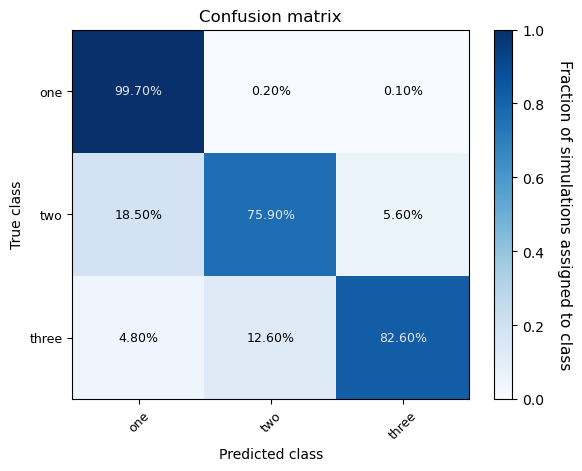

94/94 [==============================] - 0s 3ms/step
[[983  11   6]
 [157 792  51]
 [ 28 110 862]]


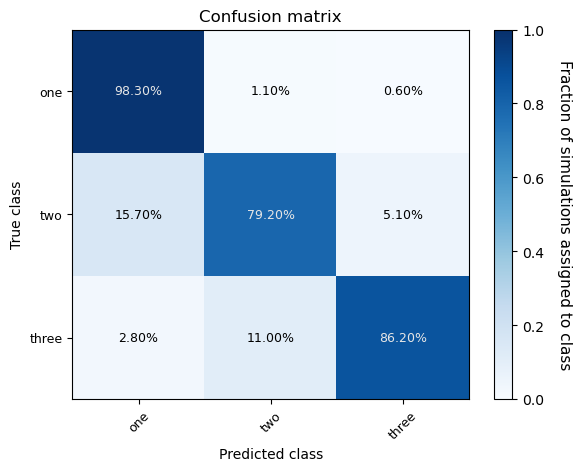

94/94 [==============================] - 0s 3ms/step


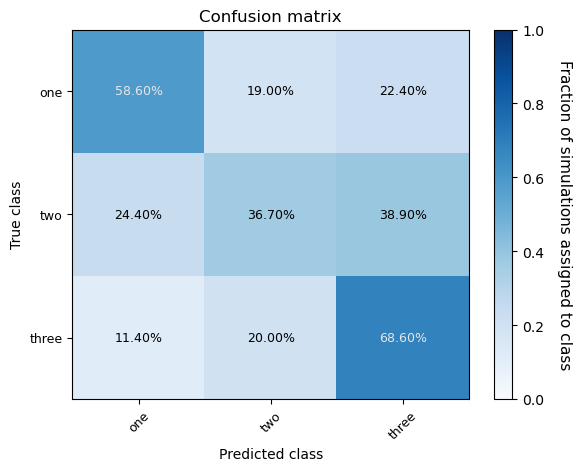

2023-03-20 13:16:40.503102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


12/94 [==>...........................] - ETA: 0s  

2023-03-20 13:16:42.222789: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 13:16:42.224558: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 13:16:42.224586: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-20 13:16:42.226346: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 13:16:42.233778: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


94/94 [==============================] - 3s 6ms/step


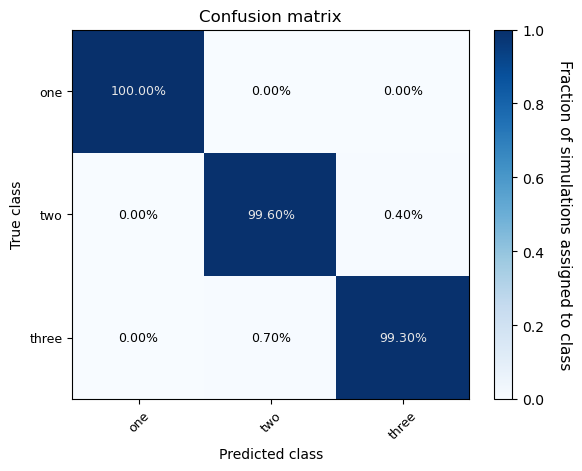

94/94 [==============================] - 1s 6ms/step


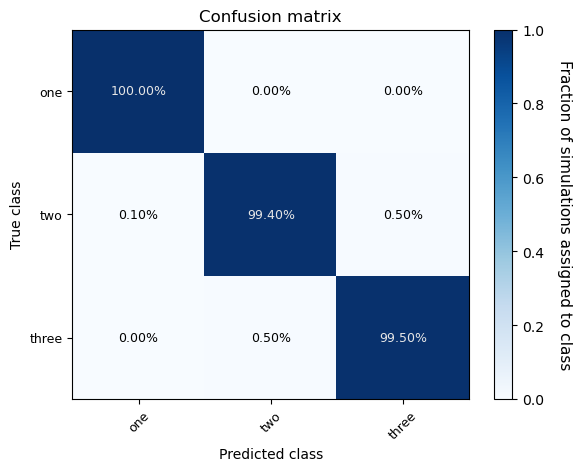

94/94 [==============================] - 1s 6ms/step


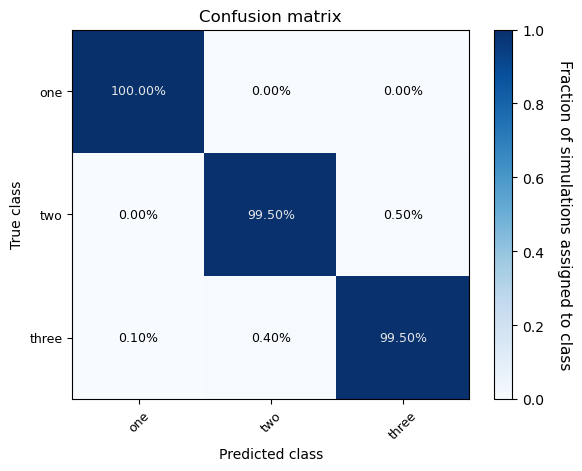

94/94 [==============================] - 1s 6ms/step


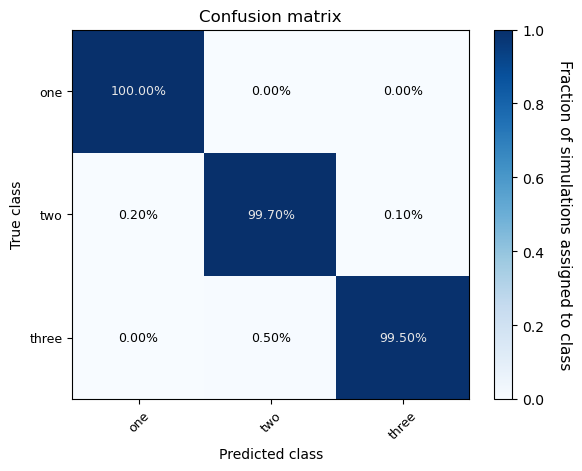

94/94 [==============================] - 1s 6ms/step


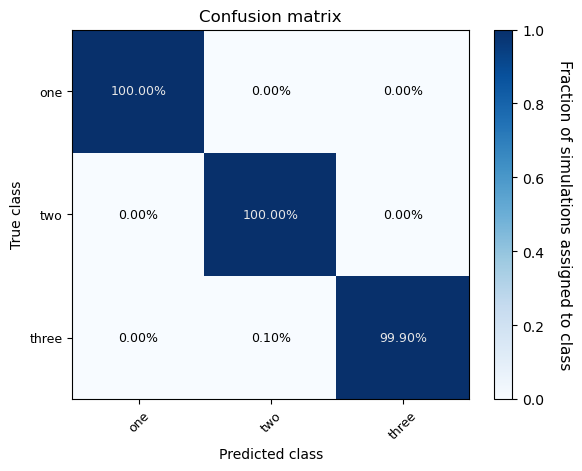

94/94 [==============================] - 1s 6ms/step


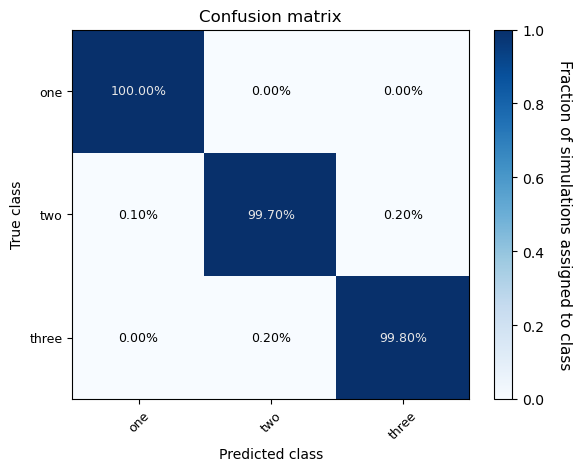

94/94 [==============================] - 1s 6ms/step


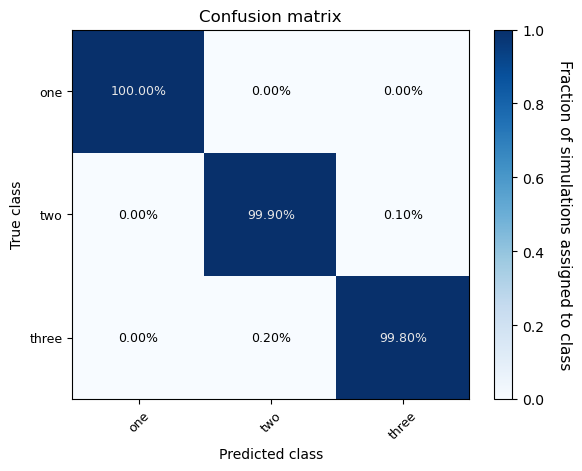

94/94 [==============================] - 0s 3ms/step
[[891  71  38]
 [ 51 697 252]
 [ 24 302 674]]


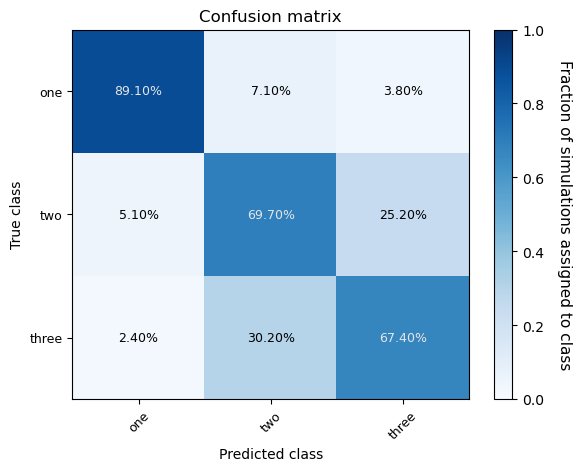

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 189  708  103]
 [  80  149  771]]


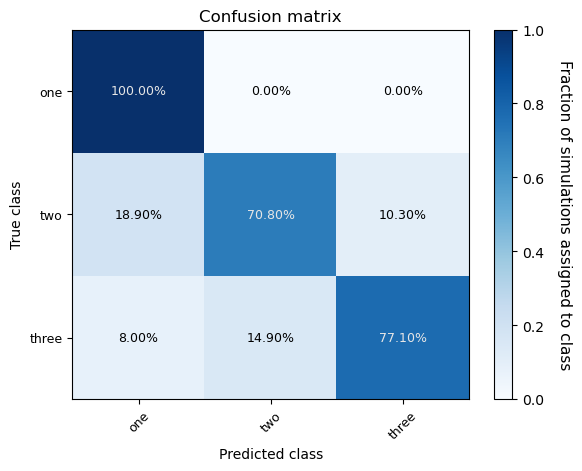

94/94 [==============================] - 0s 3ms/step


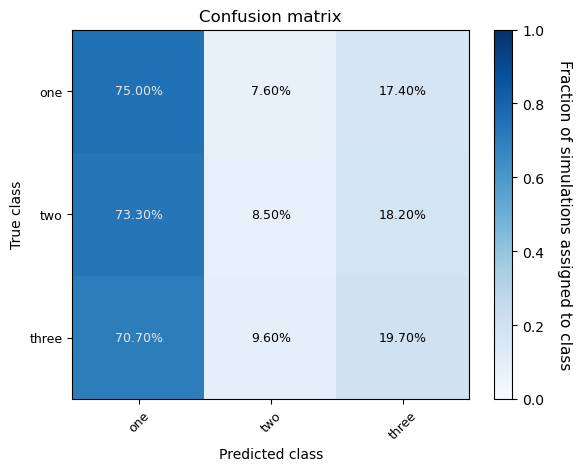

94/94 [==============================] - 1s 5ms/step


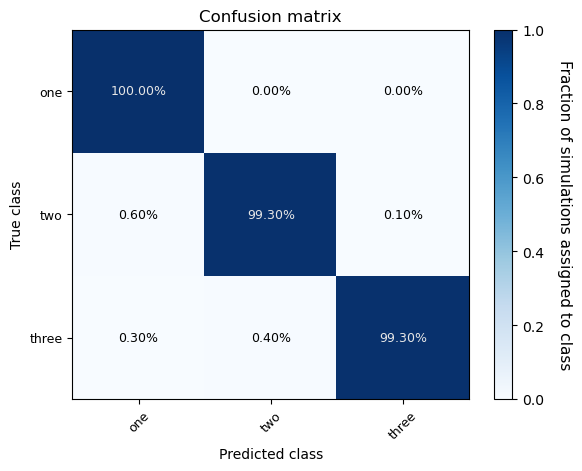

94/94 [==============================] - 1s 6ms/step


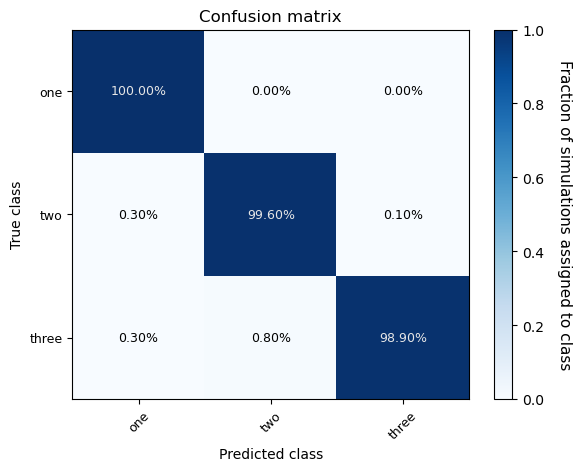

94/94 [==============================] - 1s 6ms/step


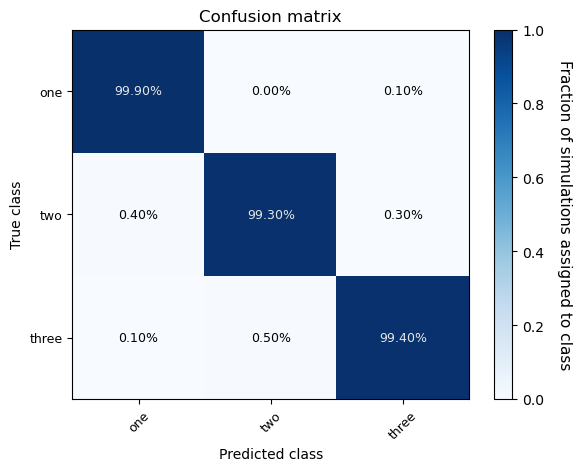

94/94 [==============================] - 1s 6ms/step


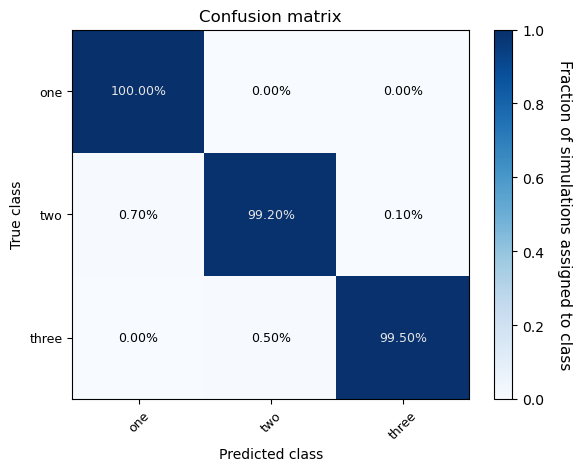

94/94 [==============================] - 1s 6ms/step


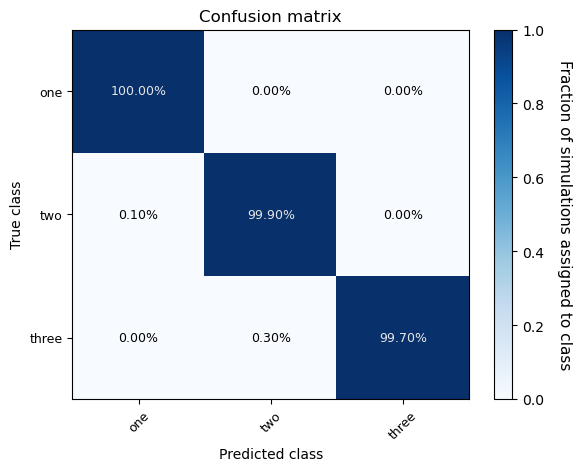

94/94 [==============================] - 1s 6ms/step


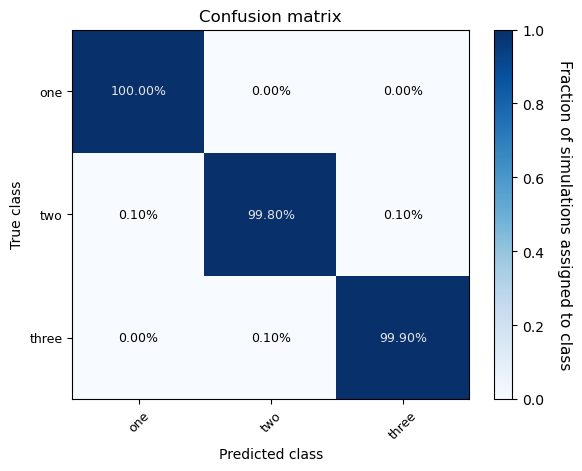

94/94 [==============================] - 1s 6ms/step


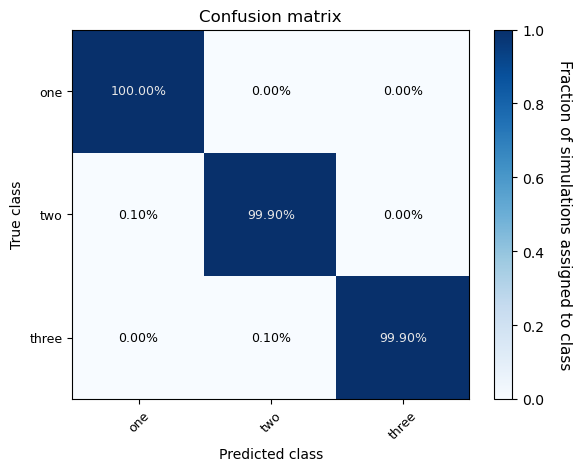

94/94 [==============================] - 0s 3ms/step
[[993   3   4]
 [178 627 195]
 [115 253 632]]


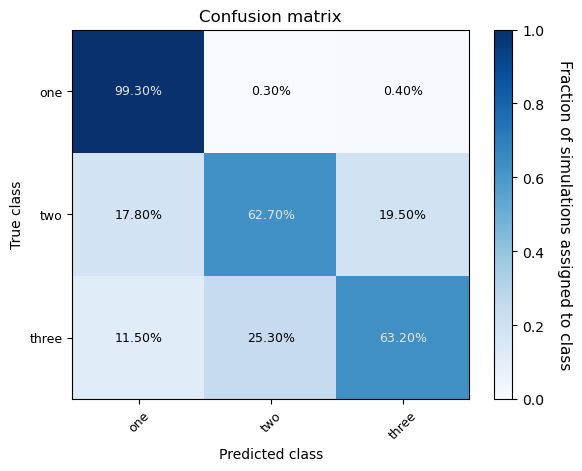

94/94 [==============================] - 0s 3ms/step
[[985   9   6]
 [204 660 136]
 [115 227 658]]


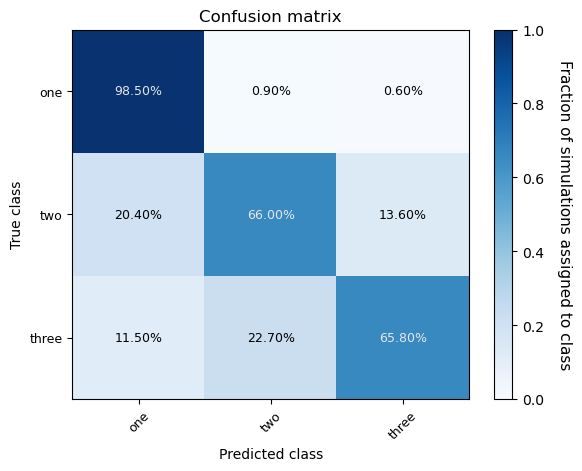

94/94 [==============================] - 0s 3ms/step


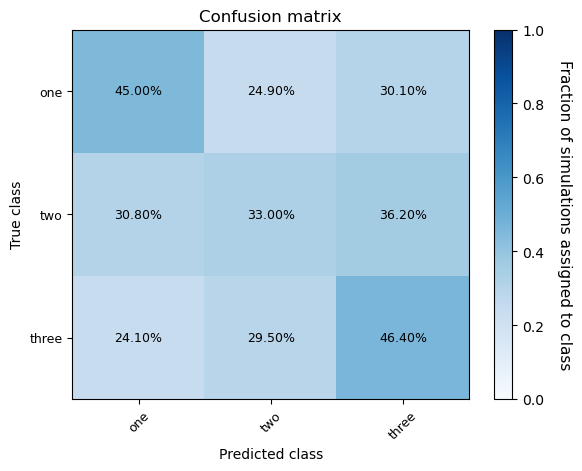

94/94 [==============================] - 1s 5ms/step


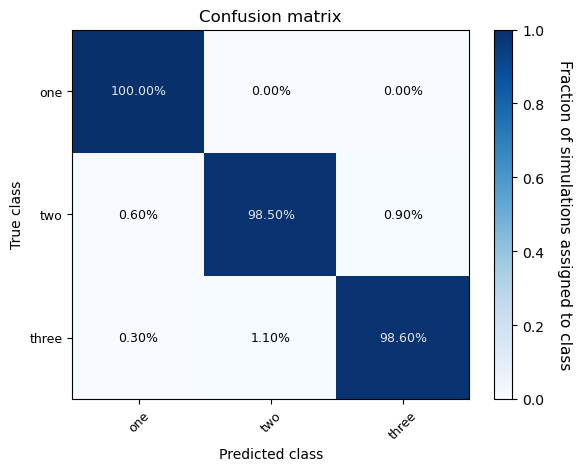

94/94 [==============================] - 1s 6ms/step


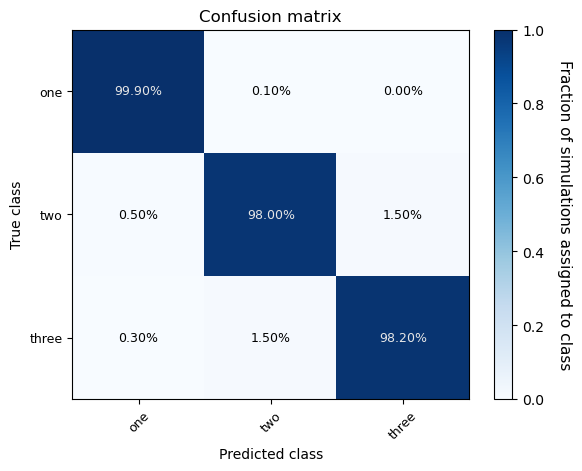

94/94 [==============================] - 1s 6ms/step


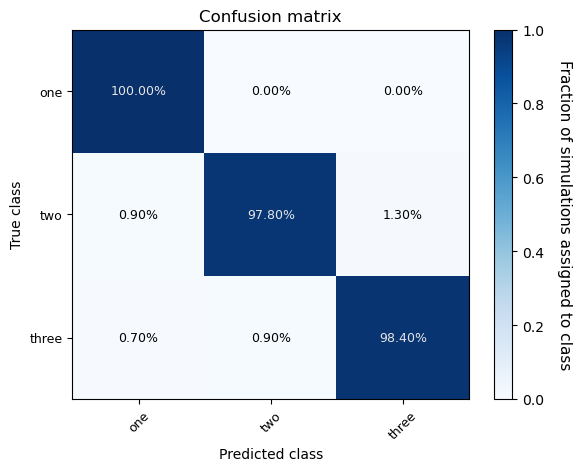

94/94 [==============================] - 1s 6ms/step


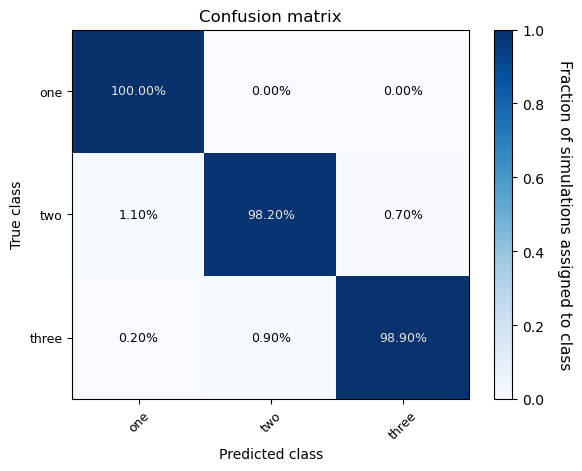

94/94 [==============================] - 1s 6ms/step


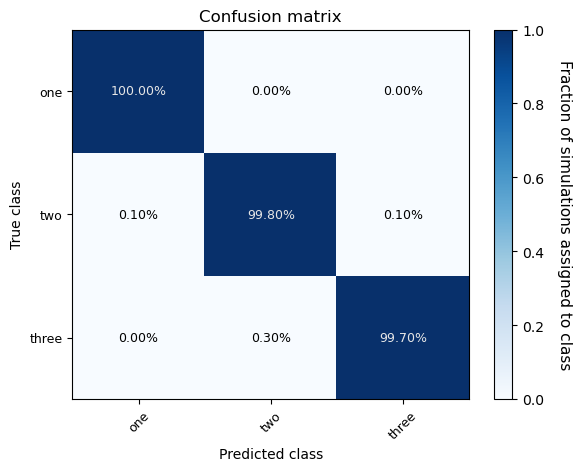

94/94 [==============================] - 2s 15ms/step


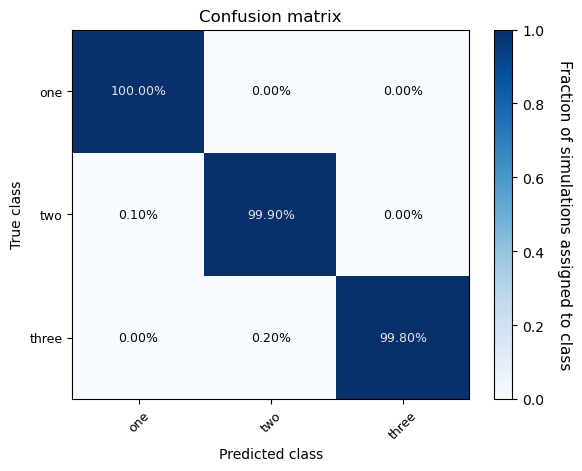

94/94 [==============================] - 1s 6ms/step


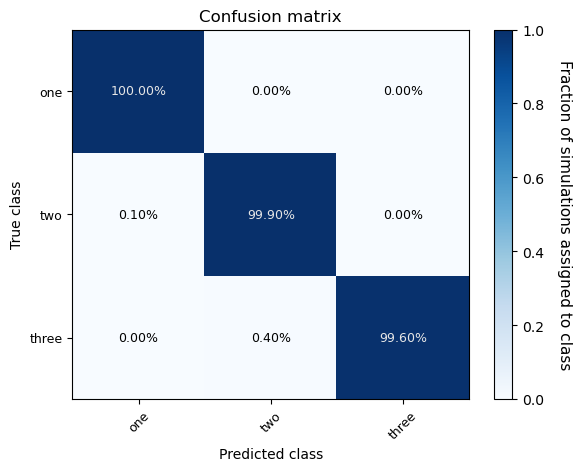

In [7]:
#here's the confusion matrix function
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    
#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model1.predict(traits_BM20.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model2.predict(traits_OU20.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model3.predict(traits_discrete20.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model4.predict(xtest20)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model5.predict([traits_BM.reshape(3000,-1), xtest20])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model6.predict([traits_OU.reshape(3000,-1), xtest20])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model7.predict([traits_discrete.reshape(3000,-1), xtest20])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model8.predict([traits_BM20.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model9.predict([traits_OU20.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model10.predict([traits_discrete20.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model11.predict(traits_BM40.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model12.predict(traits_OU40.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model13.predict(traits_discrete40.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model14.predict(xtest40)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model15.predict([traits_BM.reshape(3000,-1), xtest40])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model16.predict([traits_OU.reshape(3000,-1), xtest40])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model17.predict([traits_discrete.reshape(3000,-1), xtest40])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model18.predict([traits_BM40.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model19.predict([traits_OU40.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model20.predict([traits_discrete40.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model21.predict(traits_BM60.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model22.predict(traits_OU60.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model23.predict(traits_discrete60.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model24.predict(xtest60)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model25.predict([traits_BM.reshape(3000,-1), xtest60])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model26.predict([traits_OU.reshape(3000,-1), xtest60])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model27.predict([traits_discrete.reshape(3000,-1), xtest60])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model28.predict([traits_BM60.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model29.predict([traits_OU60.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model30.predict([traits_discrete60.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()